<a href="https://colab.research.google.com/github/SirSirocco/DataScience_2025_1/blob/colab/analyse_plan_all.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DEPENDÊNCIAS

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns

from google.colab import drive
from itertools import product
from math import sqrt
from typing import Union
from sklearn.base import BaseEstimator, clone
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from scipy import stats
from xgboost import XGBRegressor

# FUNÇÕES

## _Ad hoc_

In [ ]:
# Constantes simbólicas
class ExperimentPlan:
    pass
exp = ExperimentPlan()
exp.pre = "pre_processing"          # Pré-processamento
exp.rf = "RandomForestRegressor"    # Random Forest
exp.xgb = "XGBRegressor"            # XGBoost
exp.all = "all"                     # Todos os modelos considerados simultaneamente

exp.cv_folds = [2, 3, 5]
exp.fs_scenarios = ["na", "stateless"]
exp.metrics = ["mae", "mse", "r2"]
exp.models = [exp.rf, exp.xgb]

# Colunas do dataset
class Key():
    pass
key = Key()
key.model = "algorithm"
key.cs = "case"
key.cv_metric = "cv_metric"
key.feat = "feature"
key.fs = "col_rem"
key.imp = "importance"
key.norm = "normalization"
key.out = "outliers"
key.pca = "pca"

key.max_depth = "max_depth"
key.n_estimators = "n_estimators"

# Raízes
class Radix:
    pass
rad = Radix()
rad.avg = "cv_avg"
rad.cv = "_cv_"
rad.fold = "cv_fold"
rad.test = "best_model_test"
rad.train = "cv_avg"

# Máscaras
class Mask:
    pass
mask = Mask()
mask.fs = "FS={}"
mask.cv = "CV={}"

# Máscaras
class Format:
    pass
fmt = Format()
fmt.test = "Teste"
fmt.train = "Treino"
fmt.map_metric = {
    "mae":  "MAE (Ha)",
    "mse":  "MSE (Ha²)",
    "r2":   "R²",
}
fmt.map_param = {
    "n_estimators": "Número de estimadores",
    "max_depth": "Profundidade máxima",
}

In [ ]:
def normalize_df_exp_plan_cv(df_exp_plan: pd.DataFrame) -> pd.DataFrame:
    """
    Cada métrica usada na validação cruzada dá origem a uma linha no dataset,
    em vez de condensá-las em uma única linha. Além disso, esta função uniformiza
    os nomes, para que os resultados de diferentes V.C. possam ser comparados entre si.
    """
    RENAMING = [x for x in df_exp_plan.columns if rad.cv in x or rad.test in x]
    dfs = list()

    # Normaliza DataFrame, gerando uma linha por métrica usada na validação cruzada
    for cv_metric in exp.metrics:
        # Remove informações da C.V. das outras métricas
        dropping = [x for x in df_exp_plan.columns if not x.startswith(cv_metric) and x in RENAMING]
        df = df_exp_plan.drop(columns=dropping)

        # Retira prefixo com nome da métrica
        mapping_renaming = {x: x.removeprefix(f"{cv_metric}_") for x in RENAMING}
        df = df.rename(columns=mapping_renaming)

        # Indica métrica representada
        df[key.cv_metric] = cv_metric
        dfs.append(df)

    return pd.concat(dfs, axis=0)

def get_avg_coefs(df):
    coef_rows = list()

    for _, row in df.iterrows():
        model_name = row[key.model]

        # Converter a string do campo de importância em uma Series
        lines = str(row[key.imp]).splitlines()
        for line in lines:
            if line.strip() == "" or line.startswith("dtype:"):
                continue

            try:
                feature, value = line.strip().split()
                coef_rows.append({
                    key.feat: feature,
                    key.imp: float(value),
                    key.model: model_name
                })

            except ValueError:
                continue # Linha mal formatada, ignora

    return pd.DataFrame(coef_rows)


def get_train_metric_series(df_exp_plan: pd.DataFrame, metric):
    train_cols = [col for col in df_exp_plan.columns if rad.fold in col and metric in col]

    series = list()
    for col in train_cols:
        series.append(df_exp_plan[col])

    concated = pd.concat(series, ignore_index=True)
    concated = concated.dropna()

    return concated

def get_best_train_metric_series(df: pd.DataFrame,
                                 metric: str,
                                 mode: str = "max") -> pd.Series:
    """
    Para cada linha de df, retorna o valor 'best' (maior ou menor)
    entre as colunas {metric}_cv_fold*.

    Parâmetros
    ----------
    df : pd.DataFrame
        DataFrame com colunas como "mae_cv_fold0", "mae_cv_fold1", ...
    metric : str
        Nome da métrica (ex: "mae", "mse", "r2').
    mode : {"max", "min"}
        Se "max", retorna o maior valor de cada linha;
        se "min", retorna o menor.

    Retorno
    -------
    pd.Series
        Série com índice igual ao de df, contendo o best-value por linha.
        Linhas em que todos os folds forem NaN viram NaN aqui.
    """
    # Identifica colunas de fold para esta métrica
    prefix = f"{metric}_{rad.fold}"
    fold_cols = [c for c in df.columns if c.startswith(prefix)]
    if not fold_cols:
        raise ValueError(f"Nenhuma coluna '{prefix}…' encontrada em df")

    # Calcula o melhor por linha
    if mode == "max":
        best = df[fold_cols].max(axis=1, skipna=True)
    elif mode == "min":
        best = df[fold_cols].min(axis=1, skipna=True)
    else:
        raise ValueError("mode deve ser 'max' ou 'min'")

    return best

def get_test_metric_series(df_exp_plan: pd.DataFrame, metric):
    test_cols = [col for col in df_exp_plan.columns if rad.test in col and col.endswith(metric)]

    series = list()
    for col in test_cols:
        series.append(df_exp_plan[col])

    concated = pd.concat(series, ignore_index=True)
    concated = concated.dropna()

    return concated

In [ ]:
def is_valid_col_selection(col_selection: dict) -> bool:
    return col_selection is not None

def is_valid_series(se: pd.Series) -> bool:
    return se is not None and (not se.empty) and se.notnull().all() and pd.api.types.is_numeric_dtype(se)

In [ ]:
def dict_combine(dictionary: dict) -> list:
    """
    Gera todas as combinações possíveis entre os valores de um dicionário de listas,
    retornando uma lista de dicionários com cada combinação única.

    :param dictionary: Dicionário em que cada chave está associada a uma lista de valores possíveis.
                       Os valores devem ser iteráveis (como listas ou tuplas) e de mesmo comprimento.

    :return: Lista contendo dicionários. Cada dicionário representa uma combinação possível
             entre os valores das listas fornecidas no dicionário original. As chaves são mantidas,
             e os valores correspondem a uma das combinações do produto cartesiano.
    """
    # Passo 1: Obtemos as chaves do dicionário (ex: ["key1", "key2"])
    keys = list(dictionary.keys())

    # Passo 2: Obtemos os valores associados a cada chave (listas de possibilidades)
    # Exemplo: [["a", "b", "c"], ["d", "e", "f"]]
    values = list(dictionary.values())

    # Passo 3: Calculamos o produto cartesiano dessas listas de valores
    # Isso gera todas as combinações possíveis, como ("a", "d"), ("a", "e"), ..., ("c", "f")
    combinations = product(*values)  # Asterisco faz o desempacotamento dos elementos de values

    # Passo 4: Para cada combinação, associamos os valores às suas respectivas chaves
    # Isso é feito com a função zip, e transformamos o resultado em um dicionário
    # Resultado final: uma lista de dicionários, cada um representando uma combinação possível
    return [dict(zip(keys, combo)) for combo in combinations]

def dict_flatten(dictionary: dict, fields_to_flatten: list[str]) -> dict:
    """
    Desestrutura os campos selecionados de um dicionário, retornando apenas os atributos desejados.

    :param dictionary: Dicionário original que contém os campos a serem desestruturados.
    :param fields_to_flatten: Lista de nomes dos campos que devem ser desestruturados (flatten).

    :return: Novo dicionário contendo apenas os atributos dos campos selecionados, combinados em um nível.
    """
    dict_flat = dict()

    for field in fields_to_flatten:
        value = dictionary.get(field)
        if isinstance(value, dict):
            dict_flat.update(value)

    return dict_flat

def dict_to_flat_df(dictionary: dict, fields_to_flatten: list[str], key_name: str = "key") -> pd.DataFrame:
    """
    Converte um dicionário com estrutura aninhada em um DataFrame tabular, desestruturando
    apenas os campos especificados.

    :param dictionary: Dicionário em que cada chave representa um identificador único e cada valor é um dicionário com possíveis campos aninhados.
    :param fields_to_flatten: Lista de nomes de campos a serem desestruturados. Cada um deve
                               corresponder a uma chave cujo valor é um dicionário.
    :param key_name: Nome da coluna que armazenará os identificadores do dicionário original.
                     Padrão é "key".

    :return: DataFrame com uma coluna para os identificadores e colunas adicionais contendo os
             atributos resultantes da desestruturação dos campos selecionados.
    """
    rows = list()

    for identifier, nested_dict in dictionary.items():
        dict_flat = dict_flatten(nested_dict, fields_to_flatten)
        dict_flat[key_name] = identifier
        rows.append(dict_flat)


    df = pd.DataFrame(rows)
    df = df[[key_name] + [col for col in df.columns if col != key_name]]  # Coloca a chave primeiro
    return df

def key_part_build(attr, val, separator: str = "=") -> str:
    return separator.join([str(attr).upper(), str(val).lower()])

def key_build(key_parts: list[str], separator: str = "|") -> str:
    return separator.join(key_parts)

def key_build_from_params(params: dict[str]):
    parts = [key_part_build(k, v) for k, v in params.items()]
    return key_build(parts)

def series_combine(list_series: list[pd.Series], operations: list[-1, 1]):
    """
    Combina uma lista de séries aplicando multiplicações e divisões de acordo com a lista de operações.

    Args:
        list_series (list of pd.Series): Lista de séries a combinar.
        operations (list of int): Lista de 1 e -1, indicando multiplicação (1) ou divisão (-1).

    Returns:
        pd.Series: Série resultante da combinação.
    """
    if len(list_series) != len(operations):
        raise ValueError("'list_series' e 'operations' devem ter o mesmo tamanho.")

    # Inicializa com uma série de 1s do mesmo índice da primeira série
    result = pd.Series(1.0, index=list_series[0].index)

    for series, op in zip(list_series, operations):
        if op == 1:
            result *= series  # multiplica se op for 1
        elif op == -1:
            result /= series  # divide se op for -1
        else:
            raise ValueError("A lista de operações só pode conter 1 ou -1.")

    return result

def series_normalize(series: pd.Series, scaler, series_name: str) -> pd.Series:
    series_copy = series.copy()
    array = scaler.fit_transform(series_copy.values.reshape(-1, 1))
    return pd.Series(array.squeeze(), name=series_name)

In [ ]:
def subs_outliers(df: pd.DataFrame, columns: list[str], view: bool = False) -> pd.DataFrame:
    """
    Substitui outliers pela média. Se view for True, exibe
    dois gráficos para cada coluna: antes e depois da mudança.
    """

    # Guarda resultado anterior
    df_before = df.copy()

    for column in columns:
        # Obtém quartis 1 e 3
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)

        # Obtém IQR (Intervalo Interquartílico)
        iqr = q3 - q1

        """
        Outlier se em (-inf, Q1 - 1.5 * IQR) ou (Q3 + 1.5 * IQR, +inf).
        Subsititui outliers por NA ('not available') segundo método IQR (InterQuartile Range).
        """
        df.loc[(df[column] < q1 - 1.5 * iqr) | (df[column] > q3 + 1.5 * iqr), column] = pd.NA

        # Substitui NAs pela média
        df[column] = df[column].fillna(df[column].mean())

    if view:
        for column in columns:
            # Exibe resultado inicial
            plt.boxplot(df_before[column])
            plt.title(f"ANTES: {column}")
            plt.show()

            # Exibe novo resultado
            plt.boxplot(df[column])
            plt.title(f"DEPOIS: {column}")
            plt.show()

    return df

In [ ]:
def cross_val(model: BaseEstimator,
              X: pd.DataFrame,
              y: pd.Series,
              folds: int = 5,
              metric: str = "r2",
              shuffle: bool = True,
              random_state: int = None) -> tuple[list, list]:
    """
    Realiza validação cruzada utilizando K-Fold para treinar e avaliar um modelo,
    com base em uma métrica de desempenho fornecida.

    O modelo é clonado para cada divisão dos dados, garantindo independência entre os folds.

    :param model: Estimador compatível com o Scikit-learn (deve implementar os métodos `fit` e `predict`).
    :param X: Conjunto de dados de entrada (features).
    :param y: Vetor alvo (target) correspondente às amostras em `X`.
    :param folds: Número de partições (folds) na validação cruzada. O padrão é 5.
    :param metric: Métrica de avaliação utilizada em cada fold.
                   Pode ser uma das opções: `"r2"`, `"mse"`, `"mae"`.
                   Se inválida, `"r2"` será usada como padrão.
    :param shuffle: Indica se os dados devem ser embaralhados antes da divisão em folds.
    :param random_state: Semente de aleatoriedade para reprodutibilidade. `None` implica aleatoriedade completa.

    :return: Tupla contendo:
             - lista de modelos treinados (um por fold)
             - lista de métricas correspondentes a cada fold
    """
    DICT_METRICS = {
        "r2":   r2_score,
        "mse":  mean_squared_error,
        "mae":  mean_absolute_error
    }
    models = list() # Salva modelos por fold
    metrics = list() # Salva resultados por fold
    metric_to_use = DICT_METRICS.get(metric, r2_score) # Define métrica a ser usada (padrão é coeficiente de determinação)

    # Define os índices que delimitam as partições
    kfolds = KFold(n_splits=folds, shuffle=shuffle, random_state=random_state)

    for train_index, test_index in kfolds.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        copy = clone(model) # Evita sobrescrição do modelo
        copy.fit(X_train, y_train)

        models.append(copy)
        metrics.append(metric_to_use(y_test, copy.predict(X_test))) # Calcula métrica

    return models, metrics

In [556]:
# --- CONSTANTES SIMBÓLICAS ---
"""
Incluímos '_' ao início para evitar conflitos de nomes com o restante do código.
"""
# - Pré-processamento -
_COLUMN_REMOVAL = "col_rem"
_COLUMNS = "columns"
_NAME = "name"
_FEATURE_ENGINEERING = "feat_eng"
_OUTLIERS = "outliers"
_NORMALIZATION = "normalization"
_PCA = "pca"

PREFIXES = {
    _COLUMN_REMOVAL: "FS",
    _FEATURE_ENGINEERING: "FE",
    _OUTLIERS: "OUT",
    _NORMALIZATION: "NORM",
    _PCA: "PCA"
}

_ABSENT = "absent"
_TRUE = "true"
_FALSE = "false"

RADIXES = {
    _ABSENT: "na",
    _TRUE: "1",
    _FALSE: "0"
}

_X = "X"
_y = "y"
_PARAMS = "params"

# - Métricas -
_MAE = "mae"
_MSE = "mse"
_R2 = "r2"
DICT_METRICS = {
        _MAE: mean_absolute_error,
        _MSE: mean_squared_error,
        _R2:  r2_score,
}
_AVERAGE = "avg"
_BEST_MODEL = "best_model"
_ALGORITHM = "algorithm"
_CROSS_VAL = "cv"
_FOLD = "fold"
_TEST = "test"
_PRED = "y_pred"
_IMPORTANCE = "importance"
_RESIDUE = "residues"

# FUNÇÕES
def apply_column_removal(df, X, y, col_selection, prefix, radixes):
    if is_valid_col_selection(col_selection):
        columns = col_selection[_COLUMNS]
        df = df.drop(columns=columns)
        key = key_part_build(prefix, col_selection[_NAME]) # Indica nome da seleção de colunas
    else:
        key = key_part_build(prefix, radixes[_ABSENT])
        columns = None

    return df, X, y, key, {_COLUMN_REMOVAL: columns}

def apply_feature_engineering(df, X, y, feat_eng, prefix, radixes):
    if is_valid_series(feat_eng):
        df = pd.concat([df, feat_eng], axis=1)
        key = key_part_build(prefix, feat_eng.name.lower) # Indica nome da característica
        feat_name = feat_eng.name
    else:
        key = key_part_build(prefix, radixes[_ABSENT])
        feat_name = None

    return df, X, y, key, {_FEATURE_ENGINEERING: feat_name}

def apply_outliers(df, X, y, out, prefix, radixes):
    if out:
        df = subs_outliers(df, df.columns, view=False)
        key = key_part_build(prefix, radixes[_TRUE])
    else:
        key = key_part_build(prefix, radixes[_FALSE])

    X = df.drop(columns=[y.name])
    y = df[y.name].squeeze() # Squeeze garante ser uma série

    return df, X, y, key, {_OUTLIERS: out}

apply_normalization_scaler = StandardScaler() # Guarda scaler para reuso
def apply_normalization(df, X, y, norm, prefix, radixes):
    if norm:
        X = pd.DataFrame(apply_normalization_scaler.fit_transform(X), columns=X.columns, index=X.index)
        key = key_part_build(prefix, radixes[_TRUE])
    else:
        key = key_part_build(prefix, radixes[_FALSE])

    return df, X, y, key, {_NORMALIZATION: norm}

def apply_pca(df, X, y, pca_n, prefix, radixes):
    if pca_n > 0: # Se for passado um número não positivo, entende-se que não há PCA
        key = key_part_build(prefix, pca_n)
        # Evita que componentes superem total de colunas, o que geraria redundância
        pca_n = min(len(X.columns), pca_n)

        pca_obj = PCA(n_components=pca_n)
        pca_arr = pca_obj.fit_transform(X)
        X_pca = pd.DataFrame(
            pca_arr,
            index=X.index,
            columns=[f"pc{i + 1}" for i in range(pca_n)]
        )
    else:
        key = key_part_build(prefix, radixes[_ABSENT])
        X_pca = X

    return df, X_pca, y, key, {_PCA: pca_n}

def get_best_model(metric, models, scores):
    DICT_CRITERIA = {
        _MAE: np.argmin,
        _MSE: np.argmin,
        _R2: np.argmax
    }
    best_index = DICT_CRITERIA[metric](scores)
    best_index = best_index[0] if isinstance(best_index, np.ndarray) else best_index
    return models[best_index]

def get_residuals(
        df: pd.DataFrame,
        target: str,
        random_state: int,
        col_selections: list[dict],
        features: list[pd.Series],
        outliers: list[bool],
        normalization: list[bool],
        pcas: list[int],
        model: BaseEstimator,
        pre_processing_cases: dict,
        params: dict,
        folds: list[int],
        metrics: list[str],
        test_size: float,
        log: bool = True) -> dict:

    np.random.seed(random_state) # Fixa semente aleatória
    df_original = df.copy()
    dict_pre = dict()

    for select, feat, out, norm, pca in product(col_selections, features, outliers, normalization, pcas):
        # Etapas de pré-processamento
        steps = [
            (apply_column_removal, select, PREFIXES[_COLUMN_REMOVAL]),
            (apply_feature_engineering, feat, PREFIXES[_FEATURE_ENGINEERING]),
            (apply_outliers, out, PREFIXES[_OUTLIERS]),
            (apply_normalization, norm, PREFIXES[_NORMALIZATION]),
            (apply_pca, pca, PREFIXES[_PCA]),
        ]

        key_parts = list()          # Armazena partes da chave que descreve o caso
        dict_params = dict()        # Armazena os parâmetros que compõem o caso
        df = df_original.copy()     # Copia DataFrame original para evitar sobrescrição
        X = df.drop(columns=[target])
        y = df[target]

        # Executa etapas
        for function, param, prefix in steps:
            df, X, y, key, update = function(df, X, y, param, prefix, RADIXES)
            key_parts.append(key)
            dict_params.update(update)

        key = key_build(key_parts)
        dict_pre[key] = {_X: X, _y: y, _PARAMS: dict_params}

    count = 0
    dict_cases = dict() # Armazena os casos de experimentação
    model_name = model.__class__.__name__

    # Percorre cenários de pré-processamento
    for base_key, pre_proc_params in dict_pre.items():
        try:
            # Inicio da nova chave formado pela chave do pré-processamento e nome do modelo
            name_key_part = key_part_build(_ALGORITHM, model_name)
            base_key = key_build([base_key, name_key_part])

            # Gera conjuntos de treino e de teste
            X = pre_proc_params[_X]
            y = pre_proc_params[_y]
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

            # Gera cenários com base no número de folds e nos parâmetros do modelo
            for model_params, fold_num in product(dict_combine(params), folds):
                count += 1
                # dict_best_models = dict() # Armazena melhores modelos por métrica
                dict_scores_cross_val = dict() # Armazena pontuações médias da V.C. por métrica
                dict_scores_test = dict() # Armazena pontuações do teste por métrica
                dict_y_pred_test = dict() # Armazena predições do teste por métrica
                dict_residues = dict()

                # Gera nova chave
                key_model_params = key_build_from_params(model_params)
                key_cv_part = key_part_build(_CROSS_VAL, fold_num)
                key_new = key_build([base_key, key_cv_part, key_model_params])

                model_case = clone(model)
                model_case.set_params(**model_params)

                for metric in metrics:
                    models_cross_val, scores_cross_val = cross_val(
                                        model_case,
                                        X_train,
                                        y_train,
                                        folds=fold_num,
                                        metric=metric,
                                        shuffle=True,
                                        random_state=random_state
                    )

                    # Guarda métricas por fold
                    for fold, score in zip(range(fold_num), scores_cross_val):
                        key_cross_val_folds = key_build([metric, _CROSS_VAL, _FOLD, str(fold)], separator="_")
                        dict_scores_cross_val[key_cross_val_folds] = score

                    # Computa métrica média
                    key_cross_val_avg = key_build([metric, _CROSS_VAL, _AVERAGE], separator="_")
                    dict_scores_cross_val[key_cross_val_avg] = np.mean(scores_cross_val)

                    # Escolhe melhor modelo
                    # key_cross_val_best_model = key_build([metric, _CROSS_VAL, _BEST_MODEL])
                    best_model = get_best_model(metric, models_cross_val, scores_cross_val)
                    # dict_best_models[key_cross_val_best_model] = best_model

                    # Computa métricas do melhor modelo
                    y_pred = best_model.predict(X_test)
                    dict_residues[metric] = y_pred - y_test
                    dict_y_pred_test[metric] = y_pred
                    for internal_metric in metrics:
                        key_best_model_test = key_build([metric, _BEST_MODEL, _TEST, internal_metric], separator="_")
                        dict_scores_test[key_best_model_test] = DICT_METRICS[internal_metric](y_test, y_pred)

                    # Armazena predições para reconstrução futura dos resíduos
                    # key_y_pred_test = key_build([metric, _BEST_MODEL, _TEST, _PRED])

                # Gera dicionário de parâmetros
                combined_params = dict(pre_proc_params[_PARAMS]) # Garante que é um dicionário
                combined_params.update(model_params)
                combined_params[_ALGORITHM] = model_name

                # Extrai feature importance
                if hasattr(best_model, "feature_importances_"):
                    importances = pd.Series(best_model.feature_importances_, index=X.columns)

                elif hasattr(best_model, "get_booster"):
                    raw_importances = best_model.get_booster().get_score(importance_type="gain")
                    importances = pd.Series(raw_importances)

                    # Ajusta para X.columns se as chaves forem 'f0', 'f1', ...
                    if all(k.startswith("f") for k in importances.index):
                        importances.index = [X.columns[int(k[1:])] for k in importances.index]
                else:
                    importances = None  # Ou raise Exception se quiser abortar

                dict_cases[key_new] = {
                    _PARAMS: {**combined_params},
                    _IMPORTANCE: {_IMPORTANCE: importances},
                    _CROSS_VAL: dict_scores_cross_val,
                    _TEST: dict_scores_test,
                    _PRED: dict_y_pred_test,
                    _RESIDUE: dict_residues,
                }

                if log:
                    print(f"{count:4d} - Caso {key_new} finalizado.")

        except Exception as e:
            print(f"Erro ao processar caso {key_new}: {e}")

    return dict_cases

## Constantes

## Exibição

In [ ]:
def df_show_head(df: pd.DataFrame, n: int = 5) -> None:
    display(df.head(n))
    print(f"Shape: {df.shape}")

## Utilitário

In [ ]:
def compute_ci(x: pd.Series, confidence: float = 0.95):
    """
    Calcula intervalo de confiança (95% por padrão) e retorna também o tamanho da amostra
    """
    a = np.array(x)
    n = len(a)
    dof = n - 1 # degrees of freedom

    # Computa estatísticas amostrais
    mean = a.mean()
    std = a.std(ddof = 1) # ddof (delta dof) = 1 => divide por n - 1

    # Usa a T de Student, porque se deseja obter a média sem o conhecimento do desvio padrão
    epsilon = (std / sqrt(n)) * stats.t.ppf((1.0 + confidence) / 2.0, dof)

    return n, mean - epsilon, mean, mean + epsilon

def pvalue_welch(series0: pd.Series, series1: pd.Series, alternative: str = 'two-sided') -> float:
    """
    Calcula o p-valor de um teste t de Welch (variâncias desconhecidas e diferentes)
    entre duas amostras fornecidas como pd.Series.

    Parâmetros:
    - series1, series2: pd.Series contendo os dados das amostras.
    - alternative: 'two-sided' (padrão), 'greater' ou 'lesser'.

    Retorno:
    - p-valor do teste.
    """
    # Remove NaNs
    x = series0.dropna()
    y = series1.dropna()

    # Estatísticas descritivas
    n1, n2 = len(x), len(y)
    m1, m2 = x.mean(), y.mean()
    v1, v2 = x.var(ddof=1), y.var(ddof=1)

    # Estatística t
    se = np.sqrt(v1/n1 + v2/n2)
    t_stat = (m1 - m2) / se

    # Graus de liberdade por Welch–Satterthwaite
    df_num = (v1/n1 + v2/n2)**2
    df_den = (v1**2) / (n1**2 * (n1 - 1)) + (v2**2) / (n2**2 * (n2 - 1))
    df = df_num / df_den

    # Cálculo do p-valor
    if alternative == 'two-sided':
        pval = 2 * stats.t.sf(abs(t_stat), df)
    elif alternative == 'greater':
        pval = stats.t.sf(t_stat, df)
    elif alternative == 'lesser':
        pval = stats.t.cdf(t_stat, df)
    else:
        raise ValueError("alternative deve ser 'two-sided', 'greater' ou 'lesser'")

    return pval

def variance_ratio_test_pvalue(series1: pd.Series, series2: pd.Series, alternative: str = 'two-sided') -> float:
    """
    Teste de hipótese de razão de variâncias (teste F) entre duas amostras,
    retornando apenas o p-valor.

    Parâmetros
    ----------
    series1, series2 : pd.Series
        Amostras para comparar variâncias (NaNs são descartados).
    alternative : {'two-sided', 'greater', 'lesser'}
        Tipo de hipótese alternativa.

    Retorno
    -------
    p_value : float
        p-valor do teste.
    """
    # Remove NaNs
    x = series1.dropna()
    y = series2.dropna()

    # Tamanhos e variâncias (amostrais, ddof=1)
    n1, n2 = x.size, y.size
    v1, v2 = x.var(ddof=1), y.var(ddof=1)
    F_stat = v1 / v2

    df1, df2 = n1 - 1, n2 - 1

    if alternative == 'two-sided':
        p_lower = stats.f.cdf(F_stat, df1, df2)
        p_upper = stats.f.sf(F_stat, df1, df2)
        pval = 2 * min(p_lower, p_upper)
        pval = min(pval, 1.0)
    elif alternative == 'greater':
        pval = stats.f.sf(F_stat, df1, df2)
    elif alternative == 'lesser':
        pval = stats.f.cdf(F_stat, df1, df2)
    else:
        raise ValueError("alternative deve ser 'two-sided', 'greater' ou 'lesser'")

    return pval

def add_coef_var_column(df, var_col_name, var_col_values, ddof):
    df_copy = df.copy()
    df_copy[var_col_name] = df[var_col_values].std(axis=1, ddof=ddof) / df[var_col_values].mean(axis=1)
    return df_copy

# SETUP DO AMBIENTE

In [529]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# OBTENÇÃO DO PLANO DE EXPERIMENTAÇÃO

In [530]:
PATH = "/content/drive/MyDrive/07_per_shared/projCDat_25_1/src/03_experiment_plan/plans/experiment_plan_all.csv"
exp.df_plan = pd.read_csv(PATH)

df_show_head(exp.df_plan)

,case,col_rem,feat_eng,outliers,normalization,pca,n_estimators,max_depth,random_state,algorithm,...,importance,mae_cv_fold_2,mse_cv_fold_2,r2_cv_fold_2,mae_cv_fold_3,mae_cv_fold_4,mse_cv_fold_3,mse_cv_fold_4,r2_cv_fold_3,r2_cv_fold_4
0,FS=na|FE=na|OUT=0|NORM=0|PCA=na|ALGORITHM=rand...,NaN,NaN,False,False,0,100,6,42,RandomForestRegressor,...,_ano 1.491206e-02\n_mes ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,FS=na|FE=na|OUT=0|NORM=0|PCA=na|ALGORITHM=rand...,NaN,NaN,False,False,0,100,6,42,RandomForestRegressor,...,_ano 0.017803\n_mes ...,87498.592209,5.205987e+10,0.412158,NaN,NaN,NaN,NaN,NaN,NaN
2,FS=na|FE=na|OUT=0|NORM=0|PCA=na|ALGORITHM=rand...,NaN,NaN,False,False,0,100,6,42,RandomForestRegressor,...,_ano 0.009104\n_mes ...,66236.928523,1.836564e+10,0.588484,70640.52548,93119.710466,3.106546e+10,6.717509e+10,0.596785,0.385069
3,FS=na|FE=na|OUT=0|NORM=0|PCA=5|ALGORITHM=rando...,NaN,NaN,False,False,5,100,6,42,RandomForestRegressor,...,pc1 0.192569\npc2 0.425834\npc3 0.225...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,FS=na|FE=na|OUT=0|NORM=0|PCA=5|ALGORITHM=rando...,NaN,NaN,False,False,5,100,6,42,RandomForestRegressor,...,pc1 0.235730\npc2 0.384571\npc3 0.229...,91004.585580,5.274476e+10,0.404424,NaN,NaN,NaN,NaN,NaN,NaN


Shape: (576, 38)


# ANÁLISE

## Análise de Desempenho

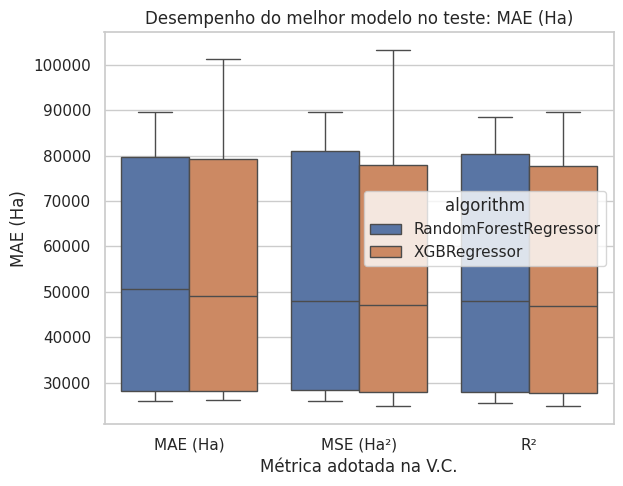

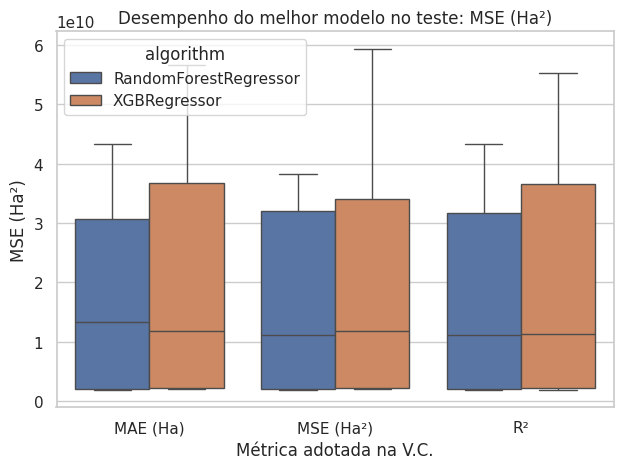

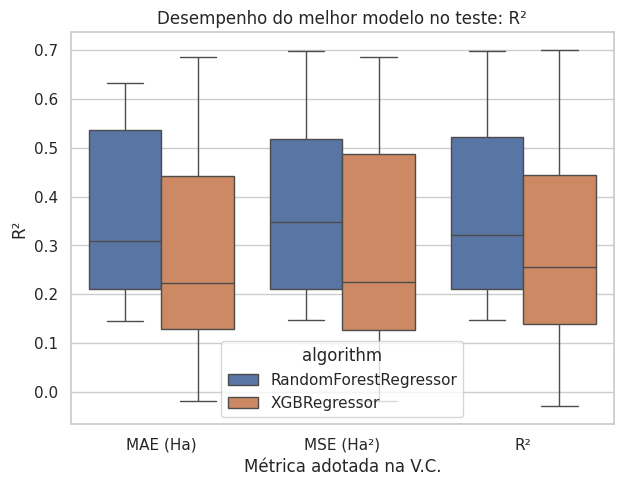

In [531]:
class Performance():
    pass
perf = Performance()

# Formatação
perf.title = "Desempenho do melhor modelo no teste: {metric}"
perf.x_axis = "Métrica adotada na V.C."
perf.y_axis = "{metric}"

# Obtém versão normalizada por validação cruzada
perf.df_normalized = normalize_df_exp_plan_cv(exp.df_plan)

# Ajusta formatação das métricas
perf.df_formatted = perf.df_normalized.copy()
perf.df_formatted[key.cv_metric] = perf.df_formatted[key.cv_metric].map(fmt.map_metric)

# Exibe resultados das métricas por melhor cenário das validações cruzadas
for metric, mapped in fmt.map_metric.items():
    metric_col = f"{rad.test}_{metric}"

    sns.boxplot(data=perf.df_formatted, x=key.cv_metric, y=metric_col, hue=key.model)
    plt.tight_layout()
    plt.title(perf.title.format(metric=mapped))
    plt.xlabel(perf.x_axis)
    plt.ylabel(perf.y_axis.format(metric=mapped))
    plt.show()

    print("\n") # Respiro visual

In [532]:
# Formatação
perf.table_title = "### Tabela comparativa de performance ###"

# Armazena resultados a comporem a tabela de desempenho
perf.data = {
    "modelo": [],
    "métrica": [],
    "média": [],
    "desvio padrão": []
}

# Constrói tabela comparativa de métricas
for metric, formatted in fmt.map_metric.items():
    for model in exp.models:
        perf.data["métrica"].append(formatted)
        perf.data["modelo"].append(model)

        df_model = perf.df_normalized[perf.df_normalized[key.model] == model]

        perf.data["média"].append(df_model[f"{rad.test}_{metric}"].mean()) # Computa média
        perf.data["desvio padrão"].append(df_model[f"{rad.test}_{metric}"].std()) # Computa desvio padrão
perf.df_cmp_table = pd.DataFrame(data=perf.data)

# Exibe tabela
print(perf.table_title)
display(perf.df_cmp_table)

### Tabela comparativa de performance ###


,modelo,métrica,média,desvio padrão
0,RandomForestRegressor,MAE (Ha),5.397250e+04,2.639074e+04
1,XGBRegressor,MAE (Ha),5.346785e+04,2.616983e+04
2,RandomForestRegressor,MSE (Ha²),1.659436e+10,1.497225e+10
3,XGBRegressor,MSE (Ha²),1.875545e+10,1.742265e+10
4,RandomForestRegressor,R²,3.719583e-01,1.693104e-01
5,XGBRegressor,R²,2.996112e-01,1.937303e-01


### Análise

## Análise de Coeficientes

Para assegurar a interpretabilidade, serão considerados apenas os casos sem PCA aplicado, isto é, com `PCA=0`.

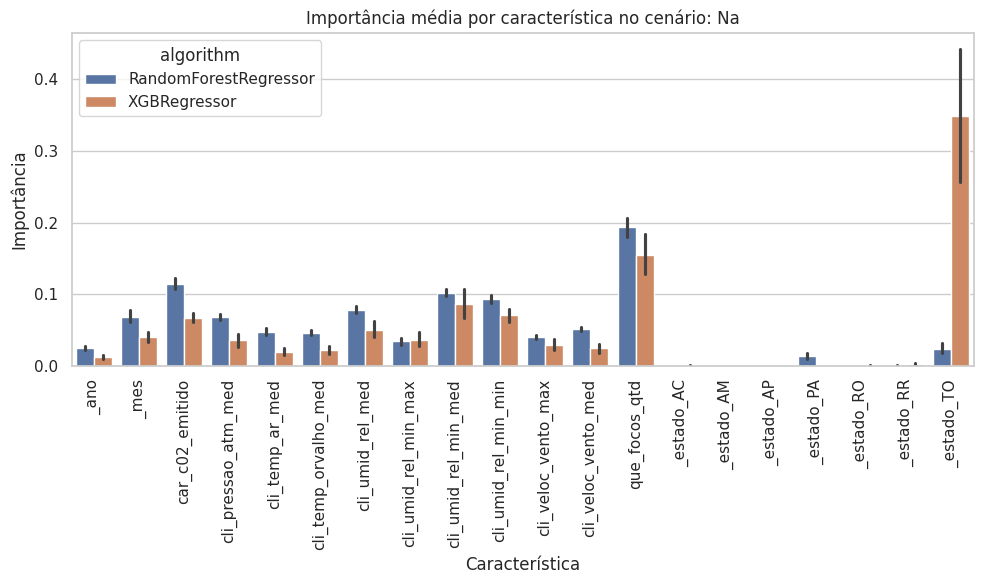

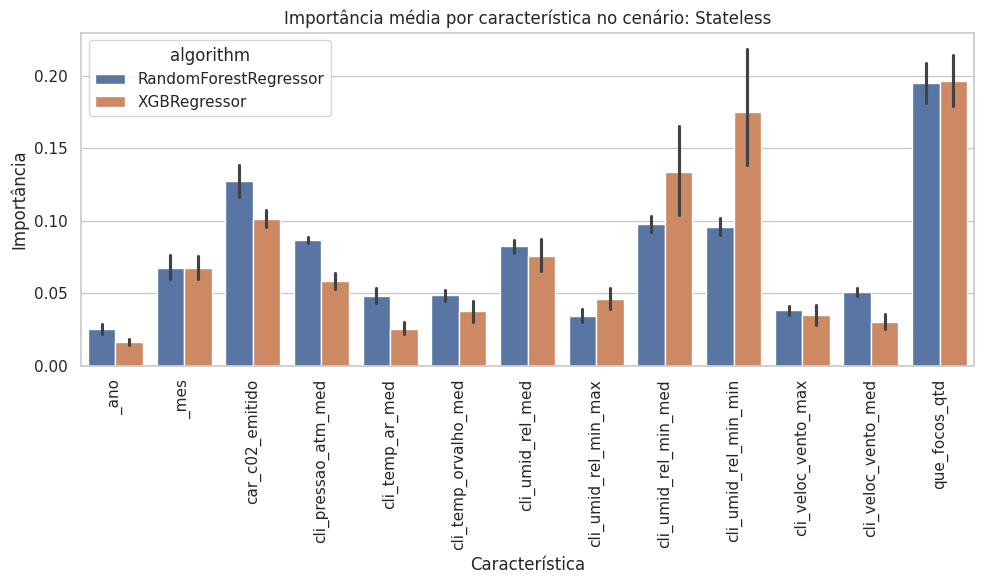

In [533]:
class Coeficient:
    pass
coef = Coeficient()

# Constantes auxiliares
coef.alpha = 5 # %

# Formatação
coef.title = "Importância média por característica no cenário: {scenario}"
coef.x_axis = "Característica"
coef.y_axis = "Importância"

# Obtém cenários sem PCA aplicado
coef.df_pcaless = exp.df_plan[exp.df_plan[key.pca] == 0]

for scenario in exp.fs_scenarios:
    # Filtra o cenário de seleção de features desejado
    coef.df_scenario = coef.df_pcaless[
        coef.df_pcaless[key.cs].apply(
            lambda x: mask.fs.format(scenario) in x
        )
    ]

    # Obtém DataFrame com a média dos coeficientes
    coef.df_avg_coefs = get_avg_coefs(coef.df_scenario)

    """
    Plota gráfico de barras da média por coeficiente com intervalo de confiança
    ao nível de significância alfa
    """
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=coef.df_avg_coefs,
        x=key.feat,
        y=key.imp,
        hue=key.model,
        errorbar=("ci", 100 - coef.alpha)
    )
    plt.title(coef.title.format(scenario=scenario.capitalize()))
    plt.xlabel(coef.x_axis)
    plt.ylabel(coef.y_axis)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

    print("\n") # Respiro visual

### Análise

## Análise de Cenários de Pré-Processamento

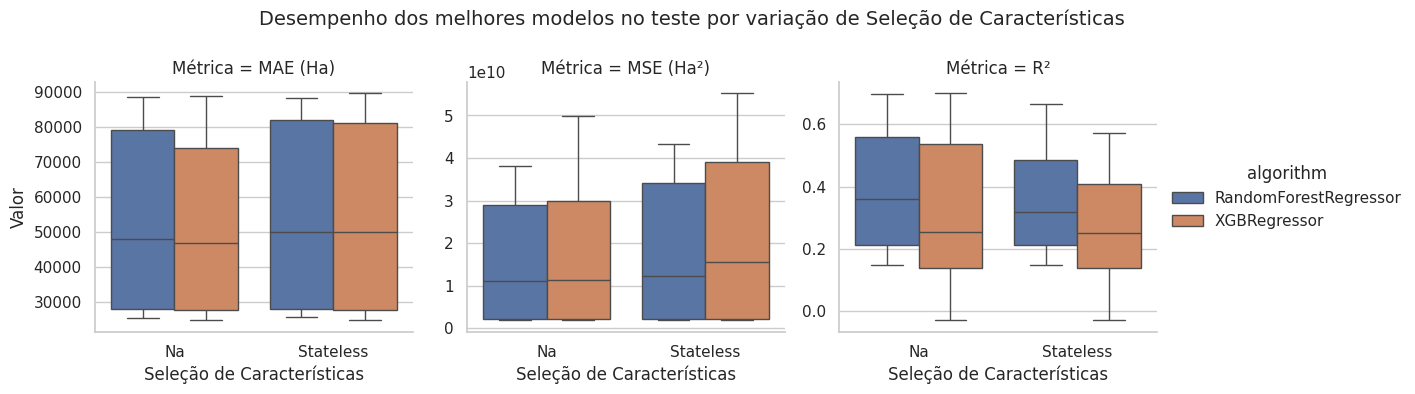

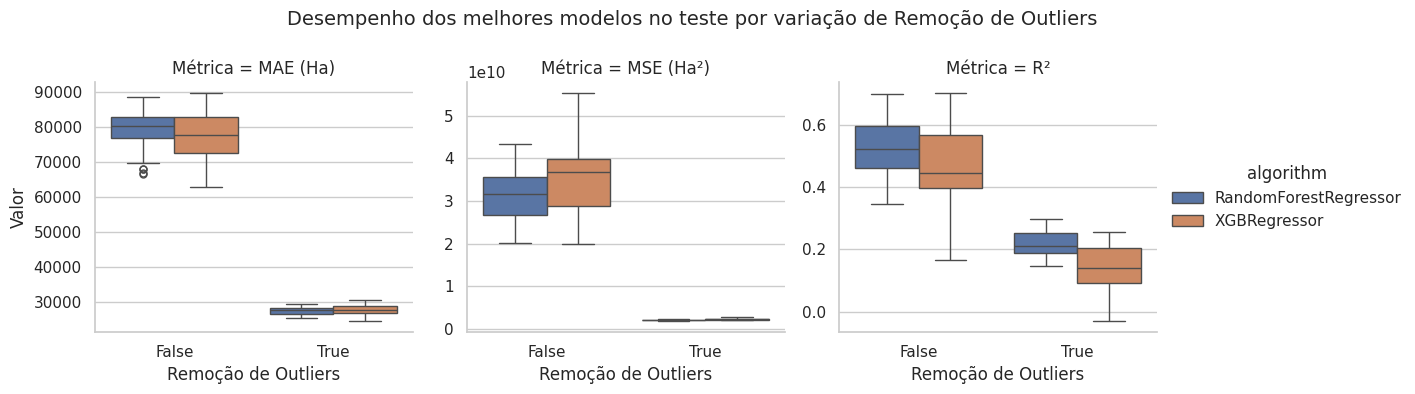

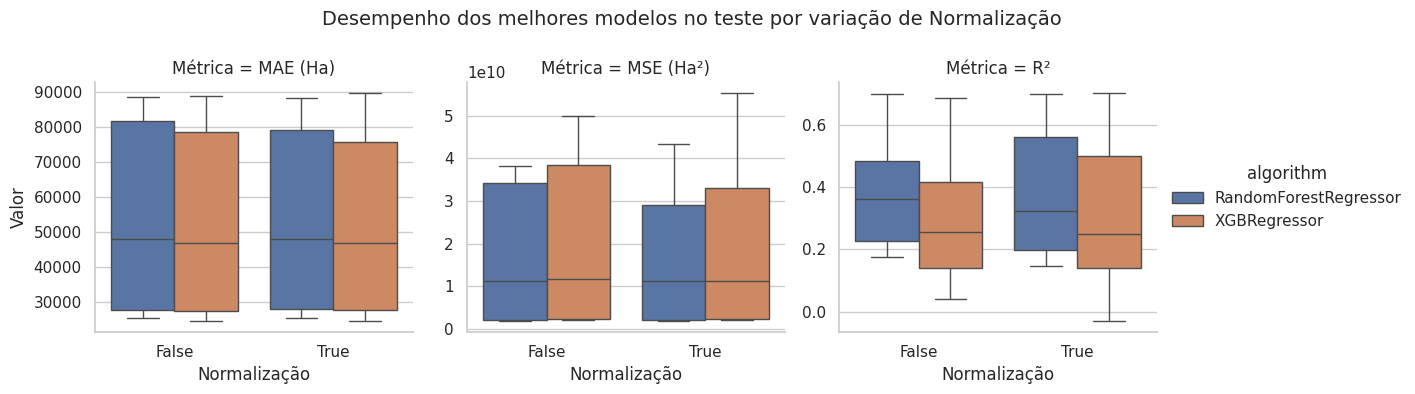

In [534]:
class PreProcessing:
    pass
pre = PreProcessing()

# Constantes auxiliares
pre.ref = "r2" # Métrica de referência usada na V.C.

pre.steps = {
    key.fs: "Seleção de Características",
    key.out: "Remoção de Outliers",
    key.norm: "Normalização"
}

pre.metrics = {
    f"{rad.test}_mae": "MAE (Ha)",
    f"{rad.test}_mse": "MSE (Ha²)",
    f"{rad.test}_r2": "R²",
}

# Formatação
pre.plot = "box"
pre.metric = "Métrica"
pre.title = "Desempenho dos melhores modelos no teste por variação de {step_name}"
pre.y_axis = "Valor"

# Restringe apenas aos casos que tenham usado a métrica de referência em sua V.C.
pre.df = normalize_df_exp_plan_cv(exp.df_plan)
pre.df = pre.df[pre.df[key.cv_metric] == pre.ref]
pre.df = pre.df.rename(columns=pre.metrics)

# Renomeia cenários
for scenario in exp.fs_scenarios:
    pre.df.loc[
        pre.df[key.cs].apply(lambda key: mask.fs.format(scenario) in key),
        key.fs
    ] = scenario.capitalize()

for step, step_name in pre.steps.items():
    # Transforma DataFrame para formato longo
    pre.df_melted = pre.df.melt(
        id_vars=[key.model, step],  # Colunas que permanecem
        value_vars=[metric for metric in pre.metrics.values()],  # Métricas
        var_name= pre.metric,
        value_name=pre.y_axis
    )

    # Plota subgráficos: um por variação do pré-processamento
    pre.g = sns.catplot(
        data=pre.df_melted,
        kind=pre.plot,
        x=step,
        y=pre.y_axis,
        hue=key.model,
        col=pre.metric,
        col_wrap=3,     # Controla quantos gráficos por linha
        height=4,
        aspect=1,
        sharey=False    # Gráficos não compartilham escala
    )
    pre.g.figure.subplots_adjust(top=0.8)
    pre.g.figure.suptitle(pre.title.format(step_name=step_name), fontsize=14)
    pre.g.set_axis_labels(step_name, pre.y_axis)
    plt.show()

    print("\n")

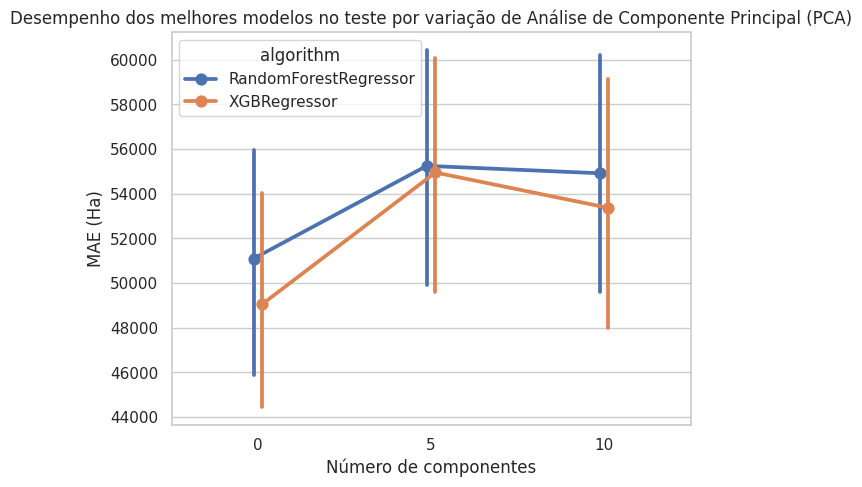

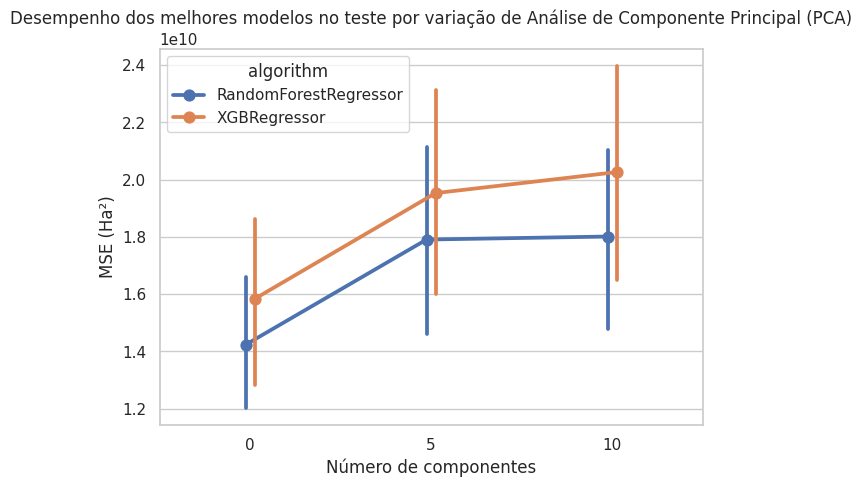

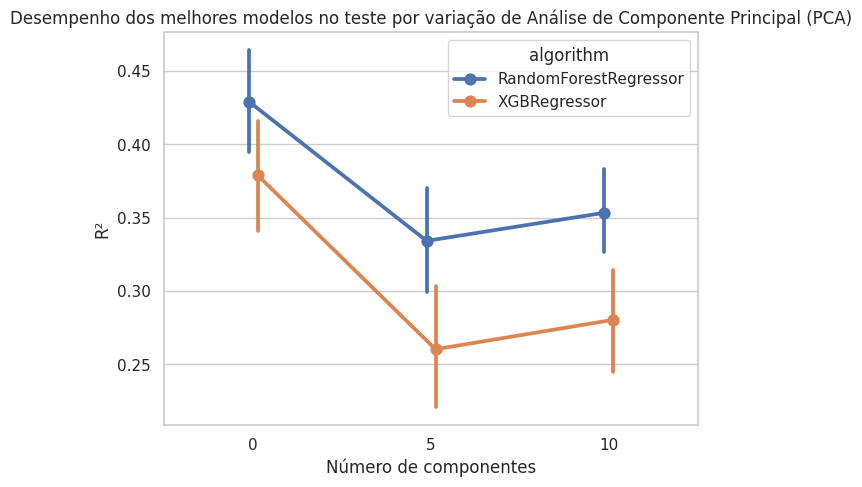

In [535]:
pre.pca = "Análise de Componente Principal (PCA)"
pre.pca_x_axis = "Número de componentes"

# Exibe pointplot por métrica
for metric in pre.metrics.values():
    sns.pointplot(data=pre.df,
                  x=key.pca,
                  y=metric,
                  hue=key.model,
                  dodge=True        # Evita sobreposição
                  )
    plt.tight_layout()
    plt.title(pre.title.format(step_name=pre.pca))
    plt.xlabel(pre.pca_x_axis)
    plt.show()

    print("\n")

### Análise

## Validação Cruzada

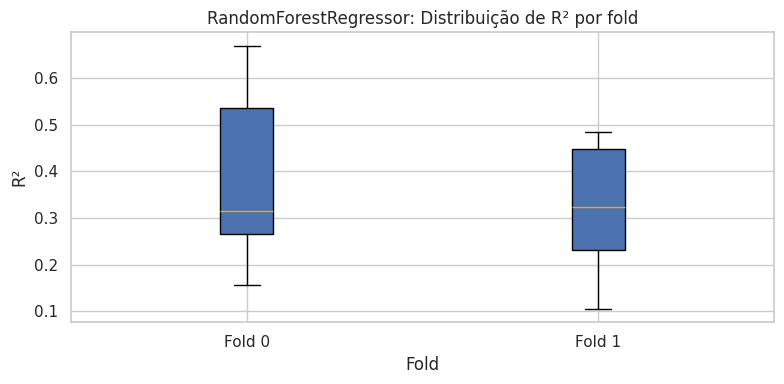

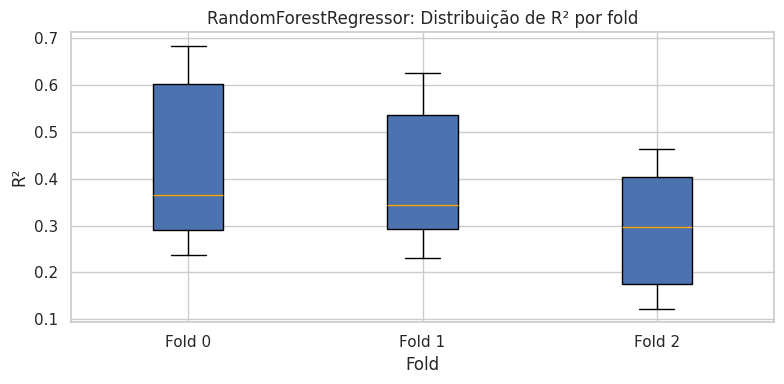

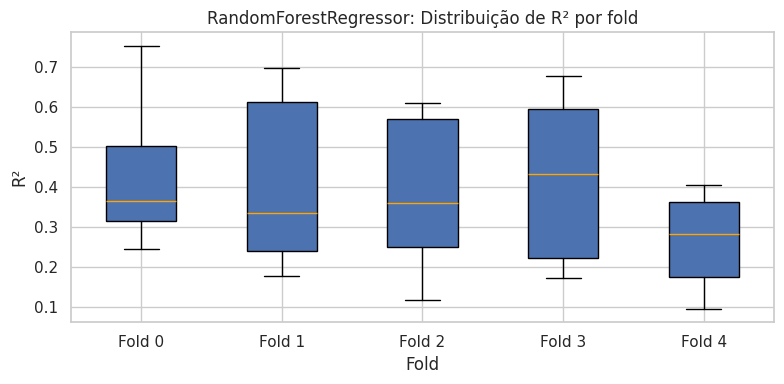

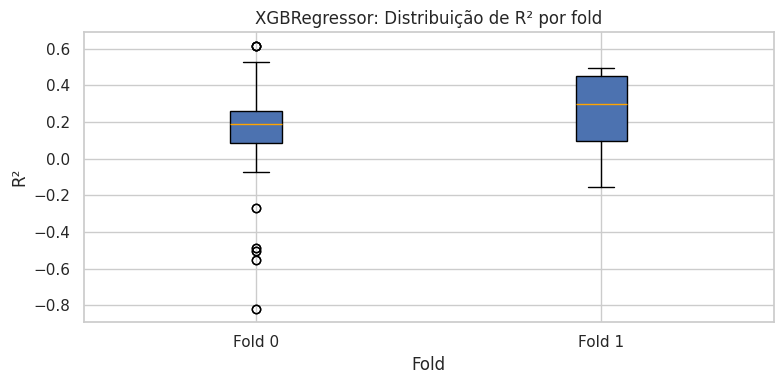

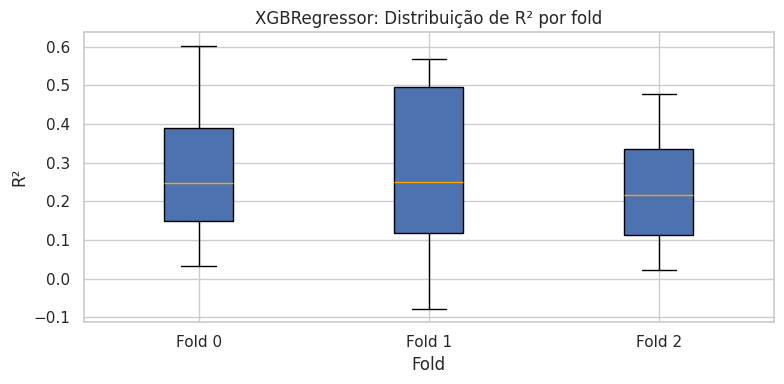

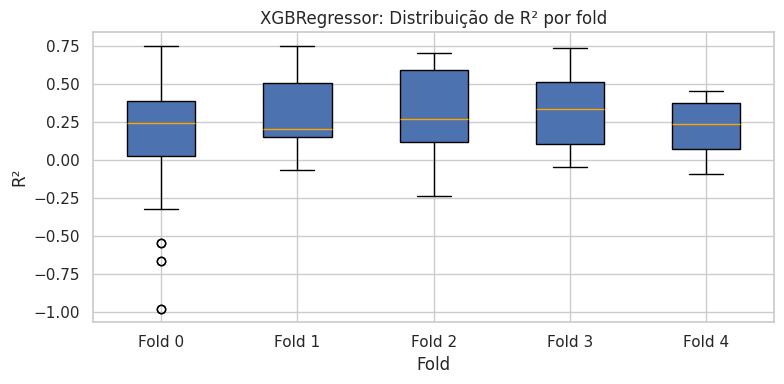

In [536]:
class CrossValidation:
    pass
cv = CrossValidation()
cv.df = normalize_df_exp_plan_cv(exp.df_plan)
cv.title = "{model}: Distribuição de {metric_name} por fold"
cv.x_label = "Fold"
cv.ref_metric = "r2" # Métrica de referência
cv.ref_metric_name = fmt.map_metric[cv.ref_metric] # Nome a ser exibido para a métrica

# Para cada modelo:
for model in exp.models:
    cv.df_model = cv.df[cv.df[key.model] == model]

    # Para cada cenário de C.V.:
    for fold_num in exp.cv_folds:
        # Seleciona apenas cenários com o número de folds em questão
        mask_cv = mask.cv.format(fold_num)
        mask_df = cv.df_model[key.cs].str.contains(mask_cv, na=False)
        cv.df_fold = cv.df_model[mask_df]
        cv.df_fold = cv.df_fold.dropna(axis=1, how="all")

        # Limita à métrica de referência
        subset = cv.df_fold[cv.df_fold[key.cv_metric] == cv.ref_metric]

        # Identifica colunas de fold
        fold_cols = [c for c in subset.columns if c.startswith(f"{rad.fold}_")]

        # Extrai números dos folds para os labels
        folds = [int(c.split('_')[-1]) for c in fold_cols]

        # Prepara os dados: lista de arrays, um para cada fold
        data = [subset[c].dropna() for c in fold_cols]

        # Plota boxplot
        plt.figure(figsize=(8, 4))
        plt.boxplot(
            data,
            tick_labels=[f"Fold {f}" for f in folds],
            patch_artist=True,
            medianprops=dict(color="orange"),
            )
        plt.title(cv.title.format(
                model=model,
                metric_name=cv.ref_metric_name
            )
        )
        plt.xlabel(cv.x_label)
        plt.ylabel(cv.ref_metric_name)
        plt.tight_layout()
        plt.show()

        print("\n") # Respiro visual

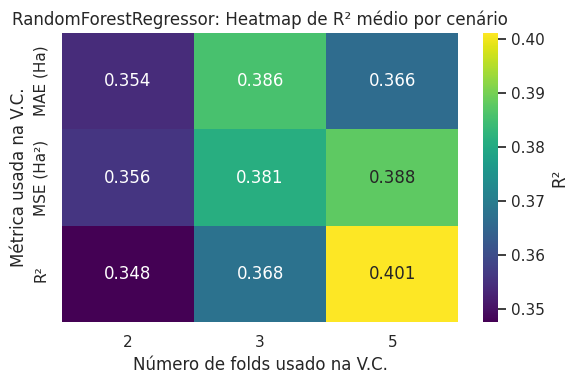

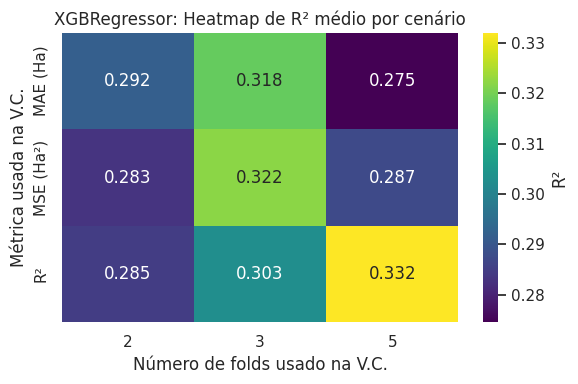

In [537]:
# Formatação
cv.heat_title = "{model}: Heatmap de {metric_name} médio por cenário"
cv.heat_x_label = "Número de folds usado na V.C."
cv.heat_y_label = "Métrica usada na V.C."
cv.heat_label = f"{cv.ref_metric_name} no conjunto de teste"

heatmap_data = pd.DataFrame(
    index=fmt.map_metric.values(),
    columns=exp.cv_folds,
    dtype=float
)

for model in exp.models:
    cv.df_model = cv.df[cv.df[key.model] == model]

    # Itera sobre cada métrica registrada
    for metric, metric_name in fmt.map_metric.items():
        cv.df_metric = cv.df_model[cv.df_model[key.cv_metric] == metric]

        # Itera por cada número de fold usado na V.C.
        for fold_num in exp.cv_folds:
            mask_cv = mask.cv.format(fold_num)
            mask_df = cv.df_metric[key.cs].str.contains(mask_cv, na=False)
            cv.df_fold = cv.df_metric[mask_df]

            # Calcula média da métrica de referência
            ref_metric_mean = cv.df_fold[f"{rad.test}_{cv.ref_metric}"].astype(float).mean()
            heatmap_data.loc[metric_name, fold_num] = ref_metric_mean

    # Plota o heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(
        heatmap_data,
        annot=True,
        fmt=".3f",
        cmap="viridis",
        cbar_kws={"label": cv.ref_metric_name}
    )
    plt.title(cv.heat_title.format(model=model, metric_name=cv.ref_metric_name))
    plt.xlabel(cv.heat_x_label)
    plt.ylabel(cv.heat_y_label)
    plt.tight_layout()
    plt.show()

    print("\n") # Respiro visual

## Análise de Cenários

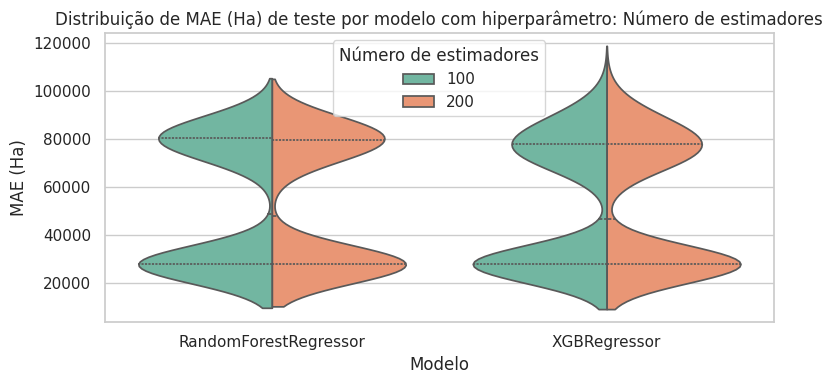

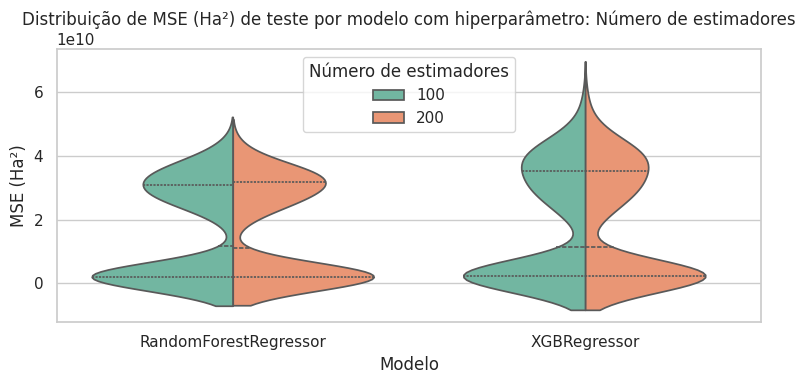

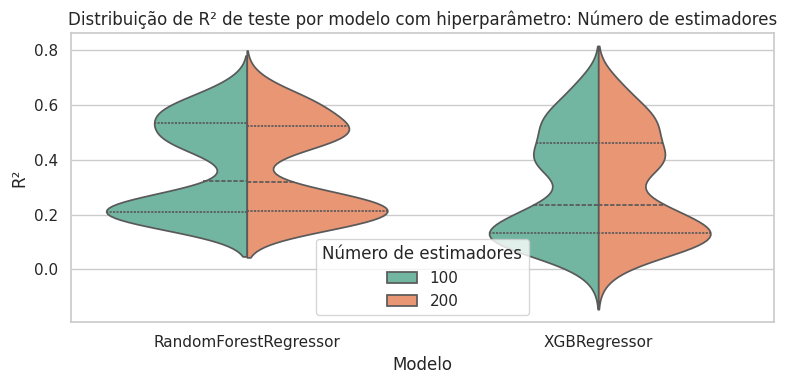

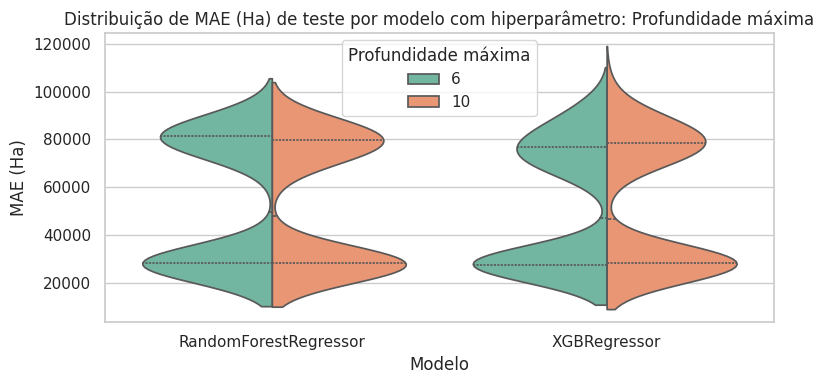

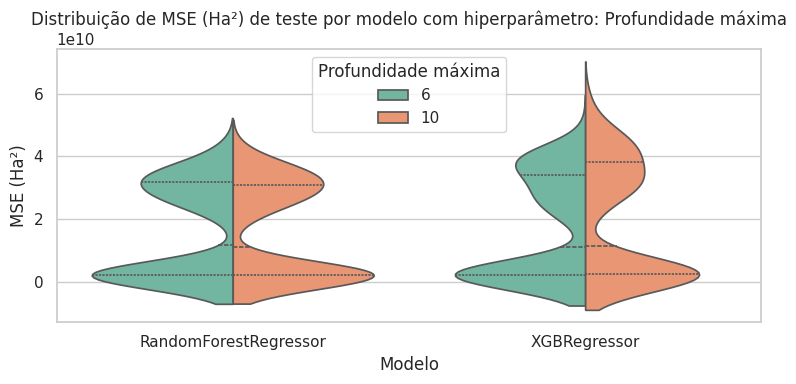

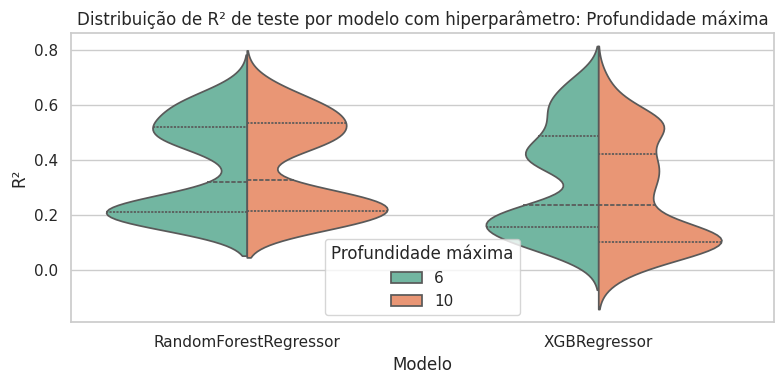

In [538]:
class ScenarioAnalysis:
    pass
sa = ScenarioAnalysis()

# Formatação
sa.title = "Distribuição de {metric_name} de teste por modelo com hiperparâmetro: {param}"
sa.x_label = "Modelo"
sa.y_label = "{metric_name}"

sa.df = normalize_df_exp_plan_cv(exp.df_plan)

# Para cada hiperparâmetro:
for param, param_name in fmt.map_param.items():
    # Para cada métrica no conjunto de teste:
    for metric, metric_name in fmt.map_metric.items():
        plt.figure(figsize=(8, 4))
        sns.violinplot(
            data=sa.df,
            x=key.model,                # Categorias
            y=f"{rad.test}_{metric}",   # Valores contínuos
            hue=param,
            split=True,                 # Se tiver só duas categorias em 'hue', divide o violino ao meio
            inner="quartile",           # Desenha quartis dentro do violino
            palette="Set2"              # Paleta de cores
        )
        plt.title(sa.title.format(metric_name=metric_name, param=param_name))
        plt.xlabel(sa.x_label)
        plt.ylabel(sa.y_label.format(metric_name=metric_name))
        plt.legend(title=param_name)
        plt.tight_layout()
        plt.show()

        print("\n") # Respiro visual

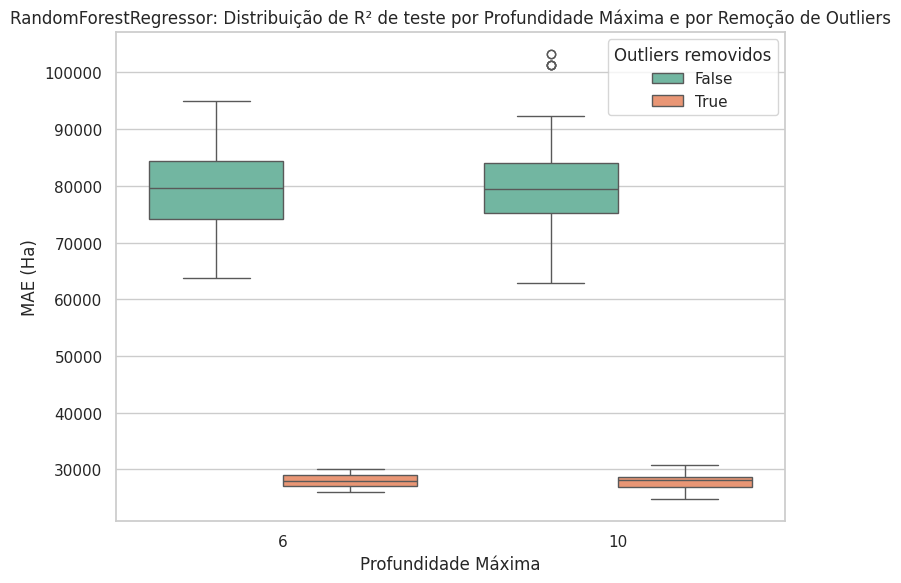

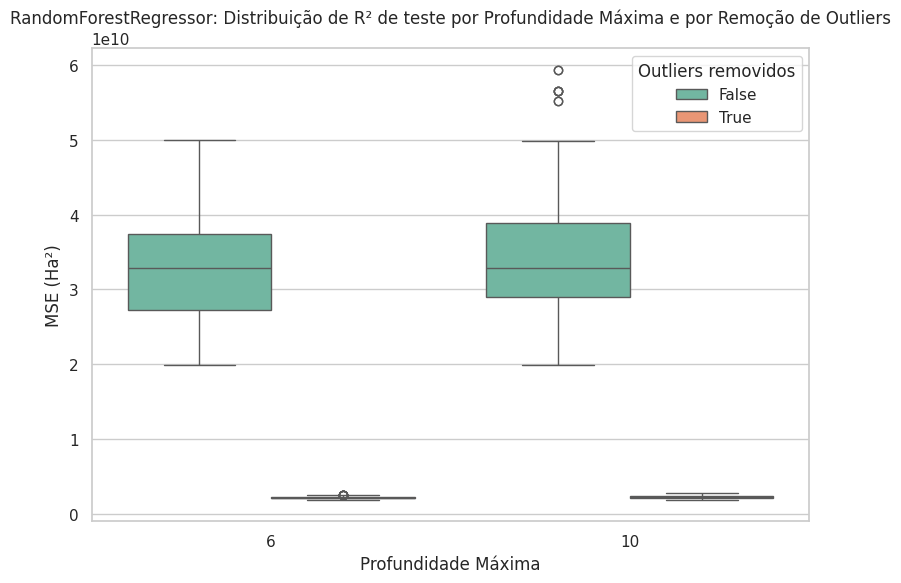

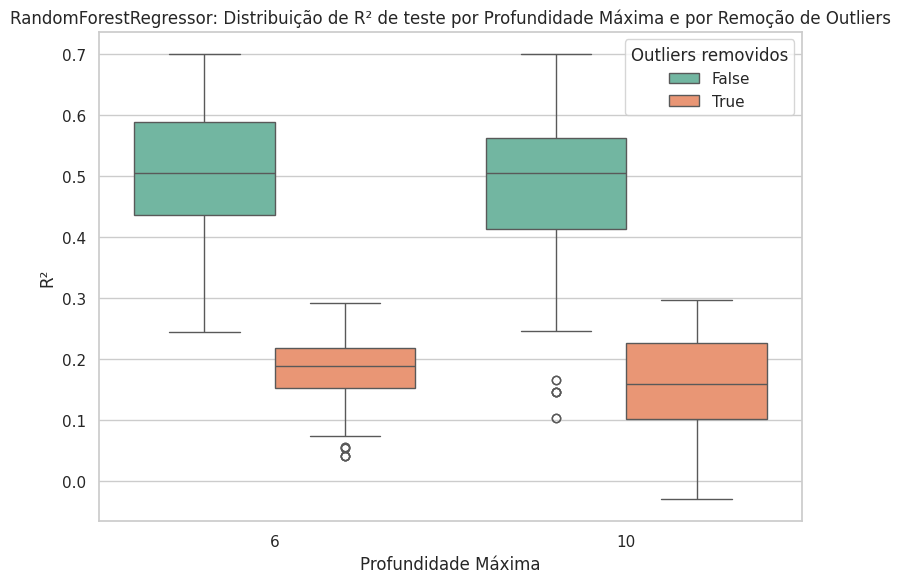

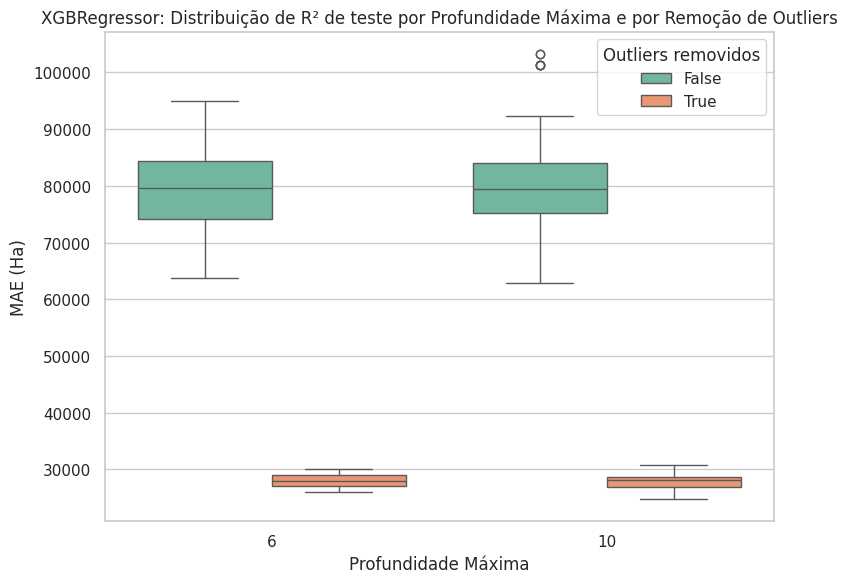

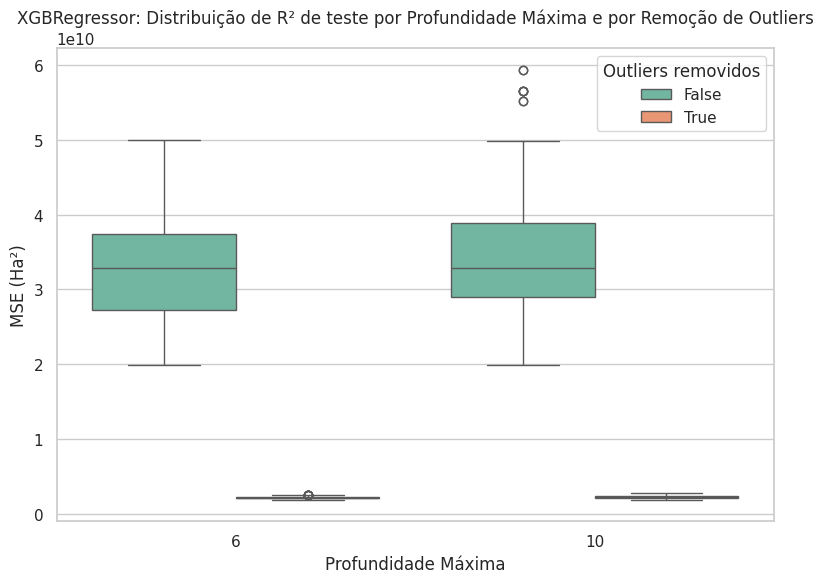

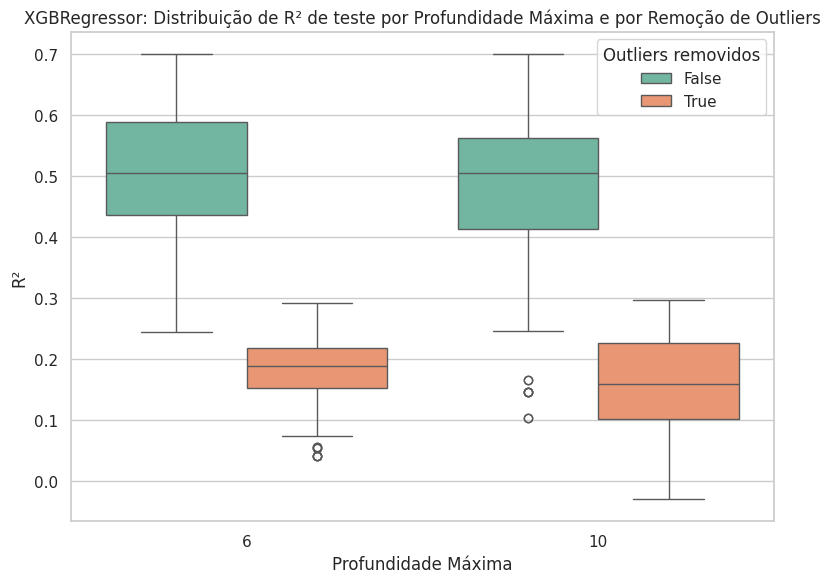

In [539]:
# Formatação
sa.out_title = "{model}: Distribuição de R² de teste por Profundidade Máxima e por Remoção de Outliers"
sa.x_label = "Profundidade Máxima"
sa.y_label = "{metric_name}"
sa.leg_title = "Outliers removidos"

for model in exp.models:
    for metric, metric_name in fmt.map_metric.items():
        # Exibe boxplot
        plt.figure(figsize=(8, 6))
        sns.boxplot(
            data=sa.df,
            x=key.max_depth,
            y=f"{rad.test}_{metric}",
            hue=key.out,
            palette="Set2"
        )
        plt.title(sa.out_title.format(model=model))
        plt.xlabel(sa.x_label)
        plt.ylabel(sa.y_label.format(metric_name=metric_name))
        plt.legend(title=sa.leg_title)
        plt.tight_layout()
        plt.show()

        print("\n") # Respiro visual

## Intervalos de Confiança

In [540]:
class ConfidenceInterval:
    pass
ci = ConfidenceInterval()
ci.alpha = 0.05
ci.conf = 1.0 - ci.alpha

# Formatação
ci.title = f"### Nível de significância pré-determinado: {ci.alpha} ###"
ci.key_model = "Modelo"
ci.key_avg = "Ponto médio"
ci.key_n = "Tamanho da amostra"
ci.key_metric = "Métrica"
ci.key_inf = "Limite inferior"
ci.key_sup = "Limite superior"
ci.key_dataset = "Conjunto"
ci.map_dataset = {
    fmt.train: get_train_metric_series,
    fmt.test: get_test_metric_series,
}

# Armazena informações da tabela
ci.data = {
    ci.key_model: [],
    ci.key_dataset: [],
    ci.key_metric: [],
    ci.key_n: [],
    ci.key_inf: [],
    ci.key_avg: [],
    ci.key_sup: [],
}
ci.df = exp.df_plan.copy()

# Computa intervalos de confiança
for model in exp.models: # Por modelo
    ci.df_model = ci.df[ci.df[key.model] == model]

    for metric, metric_name in fmt.map_metric.items(): # Por métrica
        for dataset, function in ci.map_dataset.items(): # Por dataset (treino, teste)
            ci.data[ci.key_model].append(model)
            ci.data[ci.key_dataset].append(dataset)
            ci.data[ci.key_metric].append(metric_name)

            series = function(ci.df_model, metric) # Obtém amostra de valores
            n, inf, avg, sup = compute_ci(series, ci.conf) # Calcula I.C. a partir da amostra (usa a T de Student)

            ci.data[ci.key_n].append(n)
            ci.data[ci.key_inf].append(inf)
            ci.data[ci.key_avg].append(avg)
            ci.data[ci.key_sup].append(sup)

# Constrói tabela comparativa
ci.cmp_table = pd.DataFrame(data=ci.data)
ci.cmp_table[ci.key_n] = ci.cmp_table[ci.key_n].astype("Int32")

print(ci.title)
display(ci.cmp_table)

### Nível de significância pré-determinado: 0.05 ###


,Modelo,Conjunto,Métrica,Tamanho da amostra,Limite inferior,Ponto médio,Limite superior
0,RandomForestRegressor,Treino,MAE (Ha),960,4.785526e+04,4.956075e+04,5.126624e+04
1,RandomForestRegressor,Teste,MAE (Ha),864,5.221031e+04,5.397250e+04,5.573469e+04
2,RandomForestRegressor,Treino,MSE (Ha²),960,1.542725e+10,1.669248e+10,1.795770e+10
3,RandomForestRegressor,Teste,MSE (Ha²),864,1.559462e+10,1.659436e+10,1.759411e+10
4,RandomForestRegressor,Treino,R²,960,3.689343e-01,3.791182e-01,3.893022e-01
5,RandomForestRegressor,Teste,R²,864,3.606529e-01,3.719583e-01,3.832636e-01
6,XGBRegressor,Treino,MAE (Ha),960,4.938909e+04,5.116424e+04,5.293939e+04
7,XGBRegressor,Teste,MAE (Ha),864,5.172041e+04,5.346785e+04,5.521528e+04
8,XGBRegressor,Treino,MSE (Ha²),960,1.816997e+10,1.957600e+10,2.098203e+10
9,XGBRegressor,Teste,MSE (Ha²),864,1.759209e+10,1.875545e+10,1.991881e+10


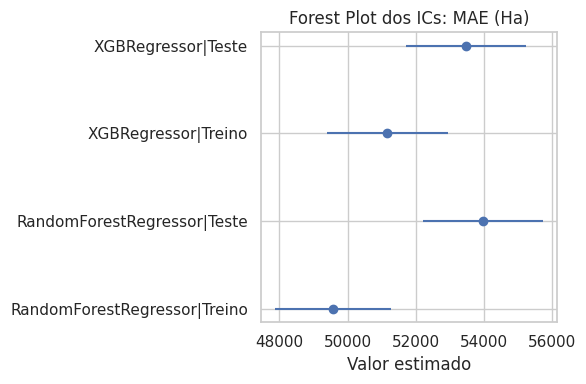

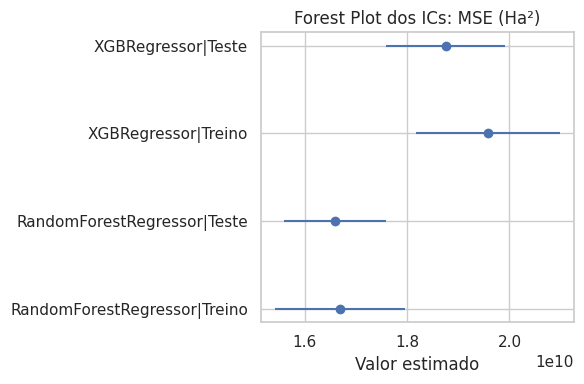

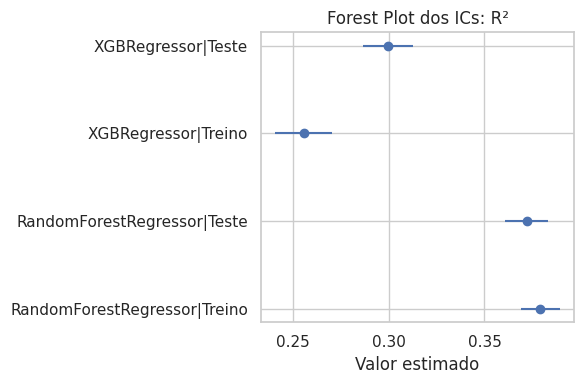

In [541]:
# Formatação
ci.forest_title = "Forest Plot dos ICs: {}"
ci.x_label = "Valor estimado"

# Exibe visualização para cada métrica
for metric in fmt.map_metric.values():
    df_aux = ci.cmp_table[ci.cmp_table[ci.key_metric] == metric]

    labels = df_aux[ci.key_model] + "|" + df_aux[ci.key_dataset]
    y = np.arange(len(labels))
    x = df_aux[ci.key_avg]
    xerr = np.vstack([
        x - df_aux[ci.key_inf],
        df_aux[ci.key_sup] - x
    ])

    # Exibe forest plot
    plt.figure(figsize=(6, 4))
    plt.errorbar(x, y, xerr=xerr, fmt='o')
    plt.title(ci.forest_title.format(metric))
    plt.xlabel(ci.x_label)
    plt.yticks(y, labels)
    plt.tight_layout()
    plt.show()

    print("\n") # Respiro visual

## Teste de Hipótese

Conforme preconizado por Fischer, seja fixado o nível de significância $\alpha = 0.05$ antes da realização dos testes de hipótese, a fim de que não haja enviesamento. A escolha do valor de $5\%$ apoia-se em sua ampla adoção pela comunidade científica, sendo uma convenção iniciada pelo próprio Fischer (1974).

### Referência
Fisher, R.A. _The design of experiments_. Nona edição. Nova Iorque: Hafner Press; 1974.

In [542]:
class HypothesisTest:
    pass
ht = HypothesisTest()
ht.alpha = 0.05
ht.map_criteria = {
    "mae": "min",
    "mse": "min",
    "r2": "max"
}

# Formatação
ht.pval_title = "\tP-Valor: {pval}"
ht.reject = "\tComo o p-valor foi maior ou igual a alfa, devemos rejeitar H0."
ht.no_reject = "\tComo o p-valor foi menor que alfa, não há evidências para rejeitar H0."

ht.df = exp.df_plan.copy()

### Comparação do desempenho entre treino e teste

Deseja-se saber se, para um dado algoritmo, o valor esperado de uma certa métrica para o melhor modelo da validação cruzada é menor no conjunto de teste que no de treino. Para tanto, definam-se as seguintes hipóteses:

Sejam $\mu_{treino}$ o valor esperado da métrica média no conjunto de treino e $\mu_{teste}$ no de teste. Defina:
<br><br>
$$
\left\{
\begin{aligned}
H_0 &: \mu_{teste} \geq \mu_{treino}\\
H_1 &: \mu_{teste} < \mu_{treino}
\end{aligned}
\right.
$$
<br>
Realize-se o teste de hipótese para todas as combinações possíveis de modelo e de métrica, a fim de determinar, com segurança, a capacidade de generalização para o conjunto de teste.

In [543]:
ht.train_test_map = {
    fmt.train: get_best_train_metric_series,
    fmt.test: get_test_metric_series,
}

# Formtação
ht.train_test_title = "### Modelo: {model} | Métrica: {metric_name} ###"

for model in exp.models: # Por modelo
    ht.df_model = ht.df[ht.df[key.model] == model]

    for metric, metric_name in fmt.map_metric.items(): # Por métrica
        # Obtém série das métricas dos melhores modelos no teste
        ht.test_sample = get_test_metric_series(ht.df_model, metric)
        ht.train_sample = get_best_train_metric_series(
                                                    ht.df_model,
                                                    metric,
                                                    ht.map_criteria[metric]
                                                    )

        # Cálculo do p-valor
        pval = pvalue_welch(ht.test_sample, ht.train_sample, "lesser")
        print(ht.train_test_title.format(model=model, metric_name=metric_name))
        print(ht.pval_title.format(pval=pval))

        # Rejeição ou não rejeição da hipótese nula
        if pval < ht.alpha:
            print(ht.no_reject)
        else:
            print(ht.reject)

        print("\n") # Respiro visual

### Modelo: RandomForestRegressor | Métrica: MAE (Ha) ###
	P-Valor: 0.9999999981510563
	Como o p-valor foi maior ou igual a alfa, devemos rejeitar H0.


### Modelo: RandomForestRegressor | Métrica: MSE (Ha²) ###
	P-Valor: 1.0
	Como o p-valor foi maior ou igual a alfa, devemos rejeitar H0.


### Modelo: RandomForestRegressor | Métrica: R² ###
	P-Valor: 9.949761406505345e-13
	Como o p-valor foi menor que alfa, não há evidências para rejeitar H0.


### Modelo: XGBRegressor | Métrica: MAE (Ha) ###
	P-Valor: 0.9999984009025944
	Como o p-valor foi maior ou igual a alfa, devemos rejeitar H0.


### Modelo: XGBRegressor | Métrica: MSE (Ha²) ###
	P-Valor: 0.9999999998858414
	Como o p-valor foi maior ou igual a alfa, devemos rejeitar H0.


### Modelo: XGBRegressor | Métrica: R² ###
	P-Valor: 1.992816097005349e-08
	Como o p-valor foi menor que alfa, não há evidências para rejeitar H0.




### Comparação entre modelos

Como _XGBoost_ é um algoritmo mais recente e, supostamente, superior ao _Random Forest_ (TIANQI _et al._, 2016), espera-se que, em geral, seu desempenho seja melhor. Vejamos se isso se confirma.

\
Sejam $\mu_{XGB}$ o valor esperado e $\sigma_{XGB}$ a variância da métrica média no conjunto de teste para o modelo `XGBoostRegressor` e $\mu_{RF}$ o valor esperado e $\sigma_{XGB}$ a variância no teste para o `RandomForestRegressor`. Defina:
<br><br>

#### Compração de precisão
$$
\left\{
\begin{aligned}
H_0 &: \mu_{XGB} > \mu_{RF}\\
H_1 &: \mu_{XGB} \leq \mu_{RF}
\end{aligned}
\right.
$$

#### Compração de robustez
$$
\left\{
\begin{aligned}
H_0 &: \sigma_{XGB} < \sigma_{RF}\\
H_1 &: \sigma_{XGB} \geq \sigma_{RF}
\end{aligned}
\right.
$$

### Referências
CHEN, Tianqi; GUESTRIN, Carlos. XGBoost: A scalable tree boosting system. _Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining_, Nova Iorque: ACM, 2016. p. 785–794.

#### Comparação de precisão

In [544]:
# Formatação
ht.train_test_title = "H0: E({xgb}) > E({rf}) | Métrica: {metric_name} ###"

# Casos por modelo
ht.df_xgb = ht.df[ht.df[key.model] == exp.xgb]
ht.df_rf = ht.df[ht.df[key.model] == exp.rf]

for metric, metric_name in fmt.map_metric.items(): # Por métrica
    # Obtém série das métricas dos melhores modelos no teste
    ht.test_xgb = get_test_metric_series(ht.df_xgb, metric)
    ht.test_rf = get_test_metric_series(ht.df_rf, metric)

    # Cálculo do p-valor
    pval = pvalue_welch(ht.test_xgb, ht.test_rf, "lesser")
    print(ht.train_test_title.format(
        xgb=exp.xgb,
        rf=exp.rf,
        metric_name=metric_name
        )
    )
    print(ht.pval_title.format(pval=pval))

    # Rejeição ou não rejeição da hipótese nula
    if pval < ht.alpha:
        print(ht.no_reject)
    else:
        print(ht.reject)

    print("\n") # Respiro visual

H0: E(XGBRegressor) > E(RandomForestRegressor) | Métrica: MAE (Ha) ###
	P-Valor: 0.34492757376733335
	Como o p-valor foi maior ou igual a alfa, devemos rejeitar H0.


H0: E(XGBRegressor) > E(RandomForestRegressor) | Métrica: MSE (Ha²) ###
	P-Valor: 0.9971247698320846
	Como o p-valor foi maior ou igual a alfa, devemos rejeitar H0.


H0: E(XGBRegressor) > E(RandomForestRegressor) | Métrica: R² ###
	P-Valor: 1.3890448956931604e-16
	Como o p-valor foi menor que alfa, não há evidências para rejeitar H0.




#### Comparação de robustez

In [545]:
# Formatação
ht.train_test_title = "V({xgb}) > V({rf}) | Métrica: {metric_name} ###"

# Casos por modelo
ht.df_xgb = ht.df[ht.df[key.model] == exp.xgb]
ht.df_rf = ht.df[ht.df[key.model] == exp.rf]

for metric, metric_name in fmt.map_metric.items(): # Por métrica
    # Obtém série das métricas dos melhores modelos no teste
    ht.test_xgb = get_test_metric_series(ht.df_xgb, metric)
    ht.test_rf = get_test_metric_series(ht.df_rf, metric)

    # Cálculo do p-valor
    pval = variance_ratio_test_pvalue(ht.test_xgb, ht.test_rf, "greater")
    print(ht.train_test_title.format(
        xgb=exp.xgb,
        rf=exp.rf,
        metric_name=metric_name
        )
    )
    print(ht.pval_title.format(pval=pval))

    # Rejeição ou não rejeição da hipótese nula
    if pval < ht.alpha:
        print(ht.no_reject)
    else:
        print(ht.reject)

    print("\n") # Respiro visual

V(XGBRegressor) > V(RandomForestRegressor) | Métrica: MAE (Ha) ###
	P-Valor: 0.5974912154945187
	Como o p-valor foi maior ou igual a alfa, devemos rejeitar H0.


V(XGBRegressor) > V(RandomForestRegressor) | Métrica: MSE (Ha²) ###
	P-Valor: 4.436617696257646e-06
	Como o p-valor foi menor que alfa, não há evidências para rejeitar H0.


V(XGBRegressor) > V(RandomForestRegressor) | Métrica: R² ###
	P-Valor: 3.892442153786335e-05
	Como o p-valor foi menor que alfa, não há evidências para rejeitar H0.




## Interpretação dos Resultados

--- Escreva aqui a interpretação ---

## Visualização dos Resultados para Escolha do Melhor Modelo

Ainda que não tão apelativa quanto um gráfico, a visualização em tabela permite comparar minuciosamente todos os parâmetros em simultâneo e de forma bastante analítica. Por tal motivo, foi escolhida para figurar nesta etapa.

\
Foi adotado o seguinte critério: escolheram-se `bm.search_size` modelos de cada algoritmo que tenham apresentado melhor resultado de teste quanto à métrica de referência `bm.ref_metric`. Neste caso:
- `bm.search_size = 5`.
- `bm.ref_metric= r2` (Coeficiente de Determinação).

\
A seguir, faz-se uma análise _ad hoc_ que considera não apenas as métricas de validação, mas também fatores de ordem prática, como o custo de execução do modelo e interpretabilidade — que decorrem diretamente dos conjunto de hiperparâmetros e dos métodos de seleção de características empregados em cada cenário.

In [546]:
class BestModel:
    pass
bm = BestModel()
bm.title = "### Melhores modelos de {model} ###"
key.coef_var = "cv_fold_coef_var"

bm.ref_metric = "r2"
bm.search_size = 5

bm.df = normalize_df_exp_plan_cv(exp.df_plan)
bm.interesting_cols = [
    key.cs,
    key.cv_metric,
    key.coef_var,
    *[x for x in bm.df if rad.fold in x],
    *[x for x in bm.df if rad.test in x],
]

bm.df = add_coef_var_column(bm.df, key.coef_var, [x for x in bm.df.columns if rad.fold in x], 1)
bm.df.sort_values(by=[f"{rad.test}_{bm.ref_metric}"], ascending=False, inplace=True)

for model in exp.models:
    bm.df_model = bm.df[bm.df[key.model] == model]
    bm.df_model = bm.df_model[bm.interesting_cols]

    # Temporarily turn off any truncation
    with pd.option_context(
        "display.max_rows",     None,
        "display.max_columns",  None,
        "display.width",        None,
        "display.max_colwidth", None
    ):
        print(bm.title.format(model=model))
        df_show_head(bm.df_model, bm.search_size)
        print("\n") # Respiro visual

### Melhores modelos de RandomForestRegressor ###


,case,cv_metric,cv_fold_coef_var,cv_fold_0,cv_fold_1,cv_fold_2,cv_fold_3,cv_fold_4,best_model_test_mae,best_model_test_mse,best_model_test_r2
227,FS=na|FE=na|OUT=0|NORM=1|PCA=na|ALGORITHM=randomforestregressor|CV=5|N_ESTIMATORS=200|MAX_DEPTH=10|RANDOM_STATE=42,r2,0.216502,7.544403e-01,6.108506e-01,6.019227e-01,6.051038e-01,3.944928e-01,66706.121351,2.004986e+10,0.697272
227,FS=na|FE=na|OUT=0|NORM=1|PCA=na|ALGORITHM=randomforestregressor|CV=5|N_ESTIMATORS=200|MAX_DEPTH=10|RANDOM_STATE=42,mse,0.827214,1.078027e+10,1.296568e+10,1.776589e+10,3.042456e+10,6.614561e+10,66706.121351,2.004986e+10,0.697272
218,FS=na|FE=na|OUT=0|NORM=0|PCA=na|ALGORITHM=randomforestregressor|CV=5|N_ESTIMATORS=200|MAX_DEPTH=10|RANDOM_STATE=42,mse,0.826761,1.078784e+10,1.298390e+10,1.779261e+10,3.035734e+10,6.612340e+10,66830.282371,2.007298e+10,0.696923
218,FS=na|FE=na|OUT=0|NORM=0|PCA=na|ALGORITHM=randomforestregressor|CV=5|N_ESTIMATORS=200|MAX_DEPTH=10|RANDOM_STATE=42,r2,0.216284,7.542678e-01,6.103038e-01,6.013240e-01,6.059762e-01,3.946961e-01,66830.282371,2.007298e+10,0.696923
74,FS=na|FE=na|OUT=0|NORM=0|PCA=na|ALGORITHM=randomforestregressor|CV=5|N_ESTIMATORS=200|MAX_DEPTH=6|RANDOM_STATE=42,r2,0.221797,7.514257e-01,5.817509e-01,5.913565e-01,5.892883e-01,3.884413e-01,69823.492993,2.109737e+10,0.681456


Shape: (864, 11)


### Melhores modelos de XGBRegressor ###


,case,cv_metric,cv_fold_coef_var,cv_fold_0,cv_fold_1,cv_fold_2,cv_fold_3,cv_fold_4,best_model_test_mae,best_model_test_mse,best_model_test_r2
446,FS=na|FE=na|OUT=0|NORM=1|PCA=5|ALGORITHM=xgbregressor|CV=5|N_ESTIMATORS=100|MAX_DEPTH=10|RANDOM_STATE=42,r2,0.410707,0.538871,0.221039,0.313349,0.615102,0.329904,66668.440201,1.988252e+10,0.699799
518,FS=na|FE=na|OUT=0|NORM=1|PCA=5|ALGORITHM=xgbregressor|CV=5|N_ESTIMATORS=200|MAX_DEPTH=10|RANDOM_STATE=42,r2,0.410724,0.538868,0.221021,0.313349,0.615105,0.329903,66667.730597,1.988253e+10,0.699799
377,FS=na|FE=na|OUT=0|NORM=1|PCA=10|ALGORITHM=xgbregressor|CV=5|N_ESTIMATORS=200|MAX_DEPTH=6|RANDOM_STATE=42,r2,0.280240,0.300250,0.346404,0.345611,0.583107,0.404276,66116.807606,1.990426e+10,0.699471
305,FS=na|FE=na|OUT=0|NORM=1|PCA=10|ALGORITHM=xgbregressor|CV=5|N_ESTIMATORS=100|MAX_DEPTH=6|RANDOM_STATE=42,r2,0.280256,0.300641,0.345621,0.345697,0.583102,0.404366,66127.836710,1.990744e+10,0.699423
521,FS=na|FE=na|OUT=0|NORM=1|PCA=10|ALGORITHM=xgbregressor|CV=5|N_ESTIMATORS=200|MAX_DEPTH=10|RANDOM_STATE=42,r2,0.287520,0.327290,0.205616,0.374699,0.476692,0.429322,62895.514566,2.070731e+10,0.687346


Shape: (864, 11)




   1 - Caso FS=na|FE=na|OUT=0|NORM=1|PCA=na|ALGORITHM=randomforestregressor|CV=5|N_ESTIMATORS=200|MAX_DEPTH=10|RANDOM_STATE=42 finalizado.


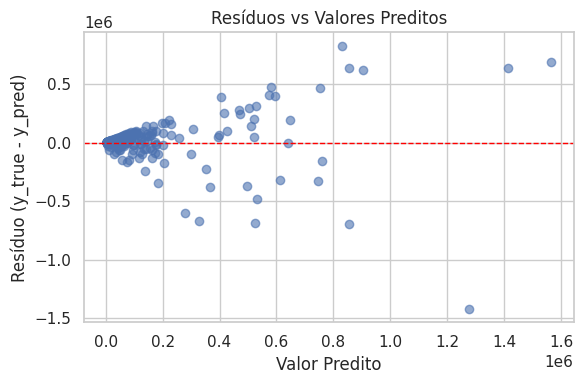

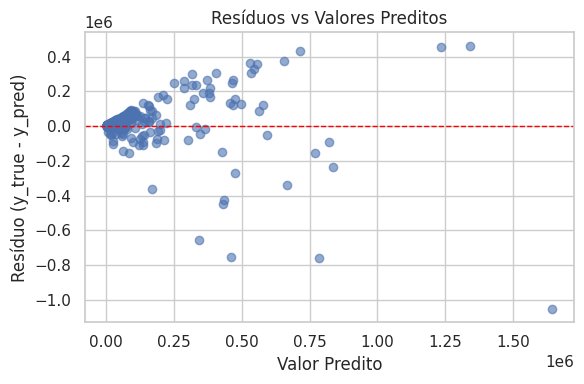

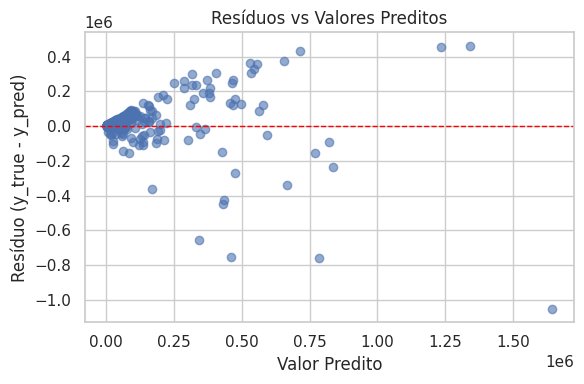

In [557]:
PATH = "/content/drive/MyDrive/07_per_shared/projCDat_25_1/datasets/cooked/_all/all_merged.csv"
df = pd.read_csv(PATH)
# Codificação OneHot simplificada
TO_ENCODE = ["_estado"]
df_encoded = pd.get_dummies(df, columns=TO_ENCODE, dtype="Int32")

bm.df_rf = bm.df[bm.df[key.model] == "RandomForestRegressor"]
bm.keys_rf = bm.df_rf.head()["case"]

dict_cases = get_residuals(
        df=df_encoded,
        target="que_area_queimada",
        random_state=42,
        col_selections=[None],
        features=[None],
        outliers=[False],
        normalization=[True],
        pcas=[0],
        model=RandomForestRegressor(),
        pre_processing_cases=None,
        params={
            "n_estimators": [200],
            "max_depth": [10],
            "random_state": [42]
        },
        folds=[5],
        metrics=exp.metrics,
        test_size=0.30,
)

for metric in exp.metrics:
    for k in bm.keys_rf.unique():
        try:
            residuals = dict_cases[k][_RESIDUE][metric]
            y_pred = dict_cases[k][_PRED][metric]

            plt.figure(figsize=(6,4))
            plt.scatter(y_pred, residuals, alpha=0.6)
            plt.axhline(0, color='red', linestyle='--', linewidth=1)
            plt.xlabel("Valor Predito")
            plt.ylabel("Resíduo (y_true - y_pred)")
            plt.title("Resíduos vs Valores Preditos")
            plt.tight_layout()
            plt.show()

        except Exception as e:
            continue

## Escolha do Melhor Modelo

--- Escolha aqui o melhor modelo ---